<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/ADMET_10_27_test_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.2 MB/s eta 0:00:00


#### Code

In [1]:
from os import walk
import os
file_types = ['bin', 'pth']
def clean_files(path='/content/drive/MyDrive/ADMET/',
                file_types = ['pth']):
    files = next(walk(path), (None, None, []))[2]
    for file in files:
        if isinstance(file, str):
            file_type = file.split('.')[-1]
            if file_type in file_types:
                os.remove(file); print(f'{file} removed from {path}')
# clean_files()

In [2]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [3]:
# test scripts.func_utils.py

from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
import pandas as pd

label_list = retrieve_label_name_list('herg_central')
names_reg = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu'] # regression task
names_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
             'CYP1A2_Veith', 'CYP2C9_Veith'] + \
            ['BBB_Martins', 'Bioavailability_Ma',
             'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS'] + \
            ['hERG_Karim', 'AMES']

names_dict = {}
for name in names_reg + names_cls:
    if name in names_reg:   names_dict[name] = True  # regression task
    elif name in names_cls: names_dict[name] = False # classification task

VOCAB_TYPE: smiles, could change from ['char', 'smiles', 'selfies'] at get_vocab.py


In [4]:

def collect_data_10_27(names:list, clean_mol_=False, verbose=False):
    if isinstance(names, str): names = [names]
    name_adme = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
                 'HydrationFreeEnergy_FreeSolv',
                 'Solubility_AqSolDB'] # regression task
    name_adme+= ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                'CYP1A2_Veith', 'CYP2C9_Veith'] + \
                ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
                 'HIA_Hou','PAMPA_NCATS'] # classify
    print('collect data for: ', names)
    label_list = retrieve_label_name_list('herg_central')
    for i, name in enumerate(names):
        if verbose: print('*'*15, name, '*'*15)
        if name in label_list: data = Tox(name='herg_central', label_name=name)
        elif name in name_adme: data = ADME(name=name)
        else:
            try: data = Tox(name=name)
            except: print('cannot read data!'); return
            if verbose: data.label_distribution()
            # data.label_distribution()
        split = data.get_split()
        train, valid, test = split['train'], split['valid'], split['test']
        if clean_mol_:
            train, valid, test = clean_mol(train), clean_mol(valid), clean_mol(test)

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if i == 0: trains, valids, tests = train.copy(), valid.copy(), test.copy()
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')

    return trains, valids, tests
# trains, valids, tests = collect_data_10_27(names_reg[0])
from scripts.get_vocab import *

def get_multi_loader(trains, valids, tests, config):
    names = config['prop_names']
    vocab = None if 'vocab' not in config else config['vocab']
    batch_size = config['batch_size']
    model_type = config['model_type']

    print('---> loader for', names)
    params_ = {'batch_size': batch_size, 'shuffle': True,
               'drop_last': False, 'num_workers': 0}
    param_t = {'batch_size': batch_size, 'shuffle': False,
               'drop_last': False, 'num_workers': 0}
    if model_type == 'RNN'and vocab == None:
        df = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
        vocab = get_vocab(df)
    train_loader = get_loader(trains, names, params_, model_type, vocab)
    valid_loader = get_loader(valids, names, params_, model_type, vocab)
    test_loader  = get_loader(tests,  names, param_t, model_type, vocab)
    return train_loader, valid_loader, test_loader, vocab

In [5]:
"""Creating vocab"""
# make_path('vocab')
# names_all = list(names_dict.keys())
# trains, valids, tests = collect_data_10_27(names_all)
# df = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
# vocab = get_vocab(df)
# vocab
# import yaml

# data = dict(
#     vocab = vocab,
#     vocab_type = 'smiles'
# )
# with open('vocab/smiles.yml', 'w') as f:
#     yaml.dump(data, f, default_flow_style=False)
# with open('vocab/smiles.yml', 'r') as f:
#     data = yaml.safe_load(f)
# data['vocab_type']

# import yaml
# model_type = 'MLP'
# names = 'CYP2C19_Veith'
# config = get_config(model_type, names)
# data = dict(
#     config = config,
#     num = 2
# )
# with open('data.yml', 'w') as f:
#     yaml.dump(data, f, default_flow_style=False)
# with open('data.yml', 'r') as f:
#     data = yaml.safe_load(f)
# data['config']
# 'a.pt'.split('.')[0] +  '.yml'

'Creating vocab'

#### Param initialization

In [9]:
in_dim = 256
hid_dims = [128, 64, 16]
dropout = 0.5
lr = 1e-4
wd = 1e-5
patience = 30 # stop if loss no decrease after epochs # patience
verbose_frequency = 20 # print evaluation every # verbose_frequency epoch
batch_size = 128

# special for AttentiveFP
graph_feat_size = 300
n_layers = 5
num_timesteps = 1 # times of updating the graph representations with GRU

# special for GIN: pretrain model types for selection:
pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                     'gin_supervised_edgepred', 'gin_supervised_masking']
pre_model_num = 0 # choose from pre_models for GIN

# special for RNN:
# if VOCAB_TYPE == 'smiles':

def load_vocab(VOCAB_TYPE):
    try:
        with open(f'vocab/{VOCAB_TYPE}.yml', 'r') as f:
            data = yaml.safe_load(f)
        vocab = data['vocab']
        assert VOCAB_TYPE == data['vocab_type']
    except: vocab = None
    return vocab

VOCAB = load_vocab(VOCAB_TYPE)

Bid = True
GRU_num_layers = 3
GRU_dim = 256

scale_dict = None

def get_config(model_type, names,
               pre_model_num=pre_model_num, scale_dict=scale_dict):
    """
    Get config to initialize model
        param model_type: str, ['MLP', 'AttentiveFP', 'GIN']
        param names: list, task names
        param scale_dict: dict,
            if the task is regression, could scale label values
                            {name: [value_min, value_max], ...}
        param pre_model_num: int, [0, 1, 2, 3]
            if model_type is 'GIN', 4 types of pretrained models to choose from
    Returns config that could be used as PRED(**config)
    """
    pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                         'gin_supervised_edgepred', 'gin_supervised_masking']

    # print(scale_dict)
    if isinstance(names, str): names = [names]
    IS_R = [names_dict[name] for name in names]
    config_MLP = {'model_type': 'MLP',
            'in_dim': 167,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr*2, # due to the simplicity of MLP, use larger lr
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_MLP.pt',
            'scale_dict': scale_dict}

    config_ATF = {'model_type': 'AttentiveFP',
            'graph_feat_size': graph_feat_size,
            'num_timesteps': num_timesteps,
            'n_layers': n_layers,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': 'ckpt_AT.pt',
            'scale_dict': scale_dict}

    config_GIN = {'model_type': 'GIN',
            'pretrain_model': pre_models_GIN[pre_model_num],
            'in_dim': in_dim,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'batch_size': batch_size,
            'IS_R': IS_R,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_GIN_{pre_models_GIN[pre_model_num]}.pt',
            'scale_dict': scale_dict}

    config_RNN = {'model_type': 'RNN',
              'vocab': VOCAB,
              'Bidirect': Bid,
              'num_layers': GRU_num_layers,
              'GRU_dim': GRU_dim,
              'out_dim': len(names),
              'prop_names': names,
              'dropout': dropout,
              'IS_R': IS_R,
              'device': 'cuda',
              'batch_size': batch_size,
              'lr': lr,
              'wd': wd,
              'patience': patience,
              'verbose_freq': verbose_frequency,
              'model_path': f'ckpt_RNN.pt',
              'scale_dict': scale_dict}

    if model_type == 'MLP':           con_MO = config_MLP
    elif model_type == 'AttentiveFP': con_MO = config_ATF
    elif model_type == 'GIN':         con_MO = config_GIN
    elif model_type == 'RNN':         con_MO = config_RNN
    else: print('Error !{MLP, AttentiveFP, GIN, RNN}'); return None
    con_MO['config_path'] = con_MO['model_path'].split('.')[0] + '.yml'
    con_MO['weight_loss'] = [1] * len(names) # different weight of task, initial weight the same
    return con_MO


In [7]:
for i, j in names_dict.items(): print(i, ': Regression? :', j)
names_all = list(names_dict.keys())

print('\nVOCAB TYPE for RNN:', VOCAB_TYPE)

Caco2_Wang : Regression? : True
Lipophilicity_AstraZeneca : Regression? : True
HydrationFreeEnergy_FreeSolv : Regression? : True
Solubility_AqSolDB : Regression? : True
LD50_Zhu : Regression? : True
CYP2C19_Veith : Regression? : False
CYP2D6_Veith : Regression? : False
CYP3A4_Veith : Regression? : False
CYP1A2_Veith : Regression? : False
CYP2C9_Veith : Regression? : False
BBB_Martins : Regression? : False
Bioavailability_Ma : Regression? : False
Pgp_Broccatelli : Regression? : False
HIA_Hou : Regression? : False
PAMPA_NCATS : Regression? : False
hERG_Karim : Regression? : False
AMES : Regression? : False

VOCAB TYPE for RNN: smiles


Found local copy...
Loading...
Done!


collect data for:  ['Lipophilicity_AstraZeneca']
scaling train valid test data set for regression task 
--> finished scaling

---> loader for ['Lipophilicity_AstraZeneca']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Epoch:0 [Train] Loss: 0.372 |  [Valid] Loss: 0.362
	 SAVE MODEL: loss: inf -> 0.362 | runtime: 2.460 ms
Epoch:1 [Train] Loss: 0.336 |  [Valid] Loss: 0.323
	 SAVE MODEL: loss: 0.362 -> 0.323 | runtime: 2.411 ms
Epoch:2 [Train] Loss: 0.288 |  [Valid] Loss: 0.250
	 SAVE MODEL: loss: 0.323 -> 0.250 | runtime: 2.465 ms
Epoch:3 [Train] Loss: 0.183 |  [Valid] Loss: 0.098
	 SAVE MODEL: loss: 0.250 -> 0.098 | runtime: 2.431 ms
Epoch:4 [Train] Loss: 0.101 |  [Valid] Loss: 0.053
	 SAVE MODEL: loss: 0.098 -> 0.053 | runtime: 2.402 ms
Epoch:5 [Train] Loss: 0.086 |  [Valid] Loss: 0.050
	 SAVE MODEL: loss: 0.053 -> 0.050 | runt

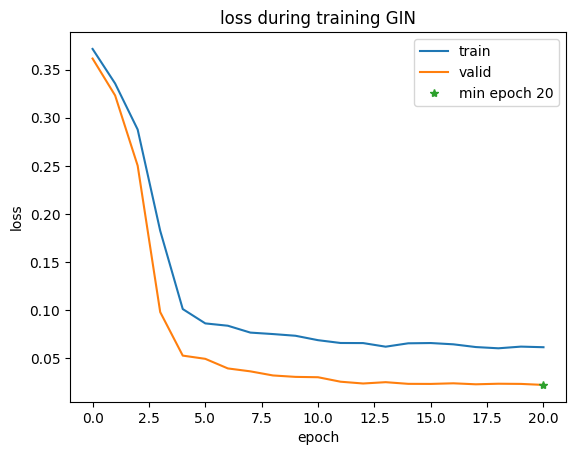

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.748  &0.807  &0.899  &0.438

Epoch:21 [Train] Loss: 0.061 |  [Valid] Loss: 0.022
	 SAVE MODEL: loss: 0.022 -> 0.022 | runtime: 2.384 ms
Epoch:22 [Train] Loss: 0.062 |  [Valid] Loss: 0.020
	 SAVE MODEL: loss: 0.022 -> 0.020 | runtime: 2.453 ms
Epoch:23 [Train] Loss: 0.058 |  [Valid] Loss: 0.021
EarlyStopping counter: 1 out of 30
Epoch:24 [Train] Loss: 0.059 |  [Valid] Loss: 0.023
EarlyStopping counter: 2 out of 30
Epoch:25 [Train] Loss: 0.058 |  [Valid] Loss: 0.023
EarlyStopping counter: 3 out of 30
Epoch:26 [Train] Loss: 0.061 |  [Valid] Loss: 0.022
EarlyStopping counter: 4 out of 30
Epoch:27 [Train] Loss: 0.058 |  [Valid] Loss: 0.024
EarlyStopping counter: 5 out of 30
Epoch:28 [Train] Loss: 0.059 |  [Valid] Loss: 0.021
EarlyStopping counter: 6 out of 30
Epoch:29 [Train] Loss: 0.058 |  [Valid] Loss: 0.021
EarlyStopping counter: 7 out of 30
Epoch:30 [Train] Loss: 0.058 |  [Valid] Loss: 0.020
	 SAVE

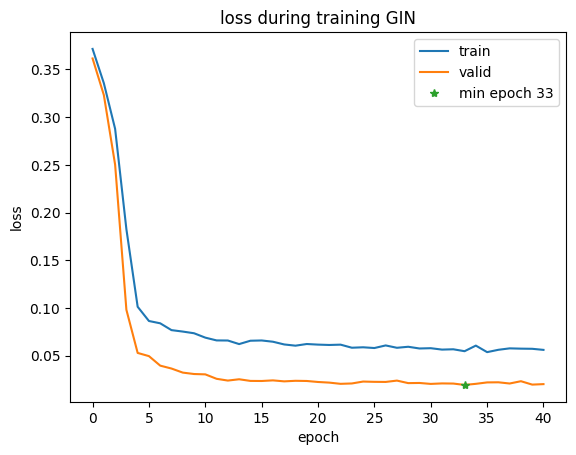

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.708  &0.727  &0.853  &0.494

Epoch:41 [Train] Loss: 0.056 |  [Valid] Loss: 0.019
	 SAVE MODEL: loss: 0.019 -> 0.019 | runtime: 2.437 ms
Epoch:42 [Train] Loss: 0.058 |  [Valid] Loss: 0.022
EarlyStopping counter: 1 out of 30
Epoch:43 [Train] Loss: 0.055 |  [Valid] Loss: 0.019
EarlyStopping counter: 2 out of 30
Epoch:44 [Train] Loss: 0.054 |  [Valid] Loss: 0.021
EarlyStopping counter: 3 out of 30
Epoch:45 [Train] Loss: 0.056 |  [Valid] Loss: 0.022
EarlyStopping counter: 4 out of 30
Epoch:46 [Train] Loss: 0.054 |  [Valid] Loss: 0.021
EarlyStopping counter: 5 out of 30
Epoch:47 [Train] Loss: 0.054 |  [Valid] Loss: 0.020
EarlyStopping counter: 6 out of 30
Epoch:48 [Train] Loss: 0.056 |  [Valid] Loss: 0.022
EarlyStopping counter: 7 out of 30
Epoch:49 [Train] Loss: 0.055 |  [Valid] Loss: 0.021
EarlyStopping counter: 8 out of 30
Epoch:50 [Train] Loss: 0.054 |  [Valid] Loss: 0.020
EarlyStopping counter: 9 o

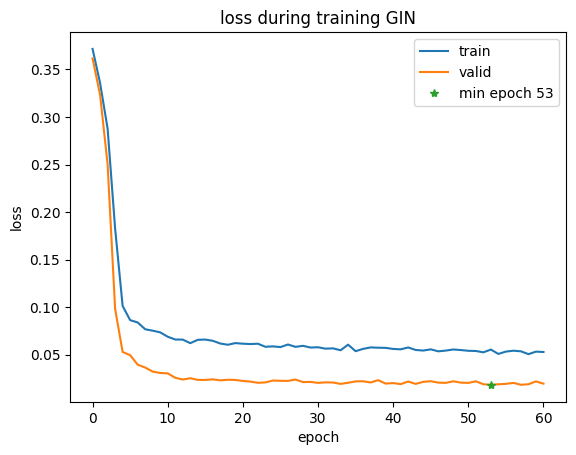

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.697  &0.705  &0.840  &0.509

Epoch:61 [Train] Loss: 0.051 |  [Valid] Loss: 0.019
EarlyStopping counter: 8 out of 30
Epoch:62 [Train] Loss: 0.052 |  [Valid] Loss: 0.020
EarlyStopping counter: 9 out of 30
Epoch:63 [Train] Loss: 0.053 |  [Valid] Loss: 0.020
EarlyStopping counter: 10 out of 30
Epoch:64 [Train] Loss: 0.050 |  [Valid] Loss: 0.017
	 SAVE MODEL: loss: 0.018 -> 0.017 | runtime: 2.380 ms
Epoch:65 [Train] Loss: 0.052 |  [Valid] Loss: 0.019
EarlyStopping counter: 1 out of 30
Epoch:66 [Train] Loss: 0.050 |  [Valid] Loss: 0.021
EarlyStopping counter: 2 out of 30
Epoch:67 [Train] Loss: 0.050 |  [Valid] Loss: 0.019
EarlyStopping counter: 3 out of 30
Epoch:68 [Train] Loss: 0.050 |  [Valid] Loss: 0.017
EarlyStopping counter: 4 out of 30
Epoch:69 [Train] Loss: 0.052 |  [Valid] Loss: 0.019
EarlyStopping counter: 5 out of 30
Epoch:70 [Train] Loss: 0.049 |  [Valid] Loss: 0.017
EarlyStopping counter: 6 

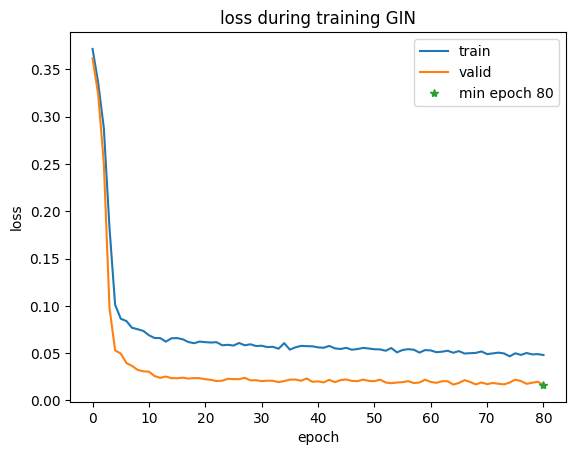

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.632  &0.591  &0.769  &0.589

Epoch:81 [Train] Loss: 0.048 |  [Valid] Loss: 0.020
EarlyStopping counter: 1 out of 30
Epoch:82 [Train] Loss: 0.046 |  [Valid] Loss: 0.021
EarlyStopping counter: 2 out of 30
Epoch:83 [Train] Loss: 0.045 |  [Valid] Loss: 0.017
EarlyStopping counter: 3 out of 30
Epoch:84 [Train] Loss: 0.046 |  [Valid] Loss: 0.018
EarlyStopping counter: 4 out of 30
Epoch:85 [Train] Loss: 0.044 |  [Valid] Loss: 0.021
EarlyStopping counter: 5 out of 30
Epoch:86 [Train] Loss: 0.044 |  [Valid] Loss: 0.020
EarlyStopping counter: 6 out of 30
Epoch:87 [Train] Loss: 0.046 |  [Valid] Loss: 0.022
EarlyStopping counter: 7 out of 30
Epoch:88 [Train] Loss: 0.045 |  [Valid] Loss: 0.020
EarlyStopping counter: 8 out of 30
Epoch:89 [Train] Loss: 0.045 |  [Valid] Loss: 0.017
EarlyStopping counter: 9 out of 30
Epoch:90 [Train] Loss: 0.043 |  [Valid] Loss: 0.019
EarlyStopping counter: 10 out of 30
Epoch:91 [

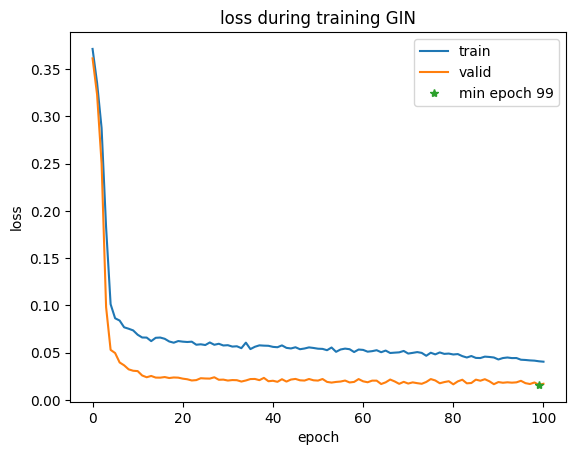

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.640  &0.612  &0.782  &0.575

Epoch:101 [Train] Loss: 0.042 |  [Valid] Loss: 0.016
	 SAVE MODEL: loss: 0.016 -> 0.016 | runtime: 2.471 ms
Epoch:102 [Train] Loss: 0.039 |  [Valid] Loss: 0.018
EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.042 |  [Valid] Loss: 0.015
	 SAVE MODEL: loss: 0.016 -> 0.015 | runtime: 2.452 ms
Epoch:104 [Train] Loss: 0.042 |  [Valid] Loss: 0.017
EarlyStopping counter: 1 out of 30


In [ ]:
# names = ['CYP2C19_Veith','CYP2D6_Veith', 'CYP3A4_Veith',
#                     'CYP1A2_Veith', 'CYP2C9_Veith']

# trains, valids, tests = collect_data_10_27(names[:1])

# print(f'train: {len(trains)} | valid: {len(valids)} | test: {len(tests)} | '
#       f'total: {len(trains) + len(valids) + len(tests)}')

# model_types = ['MLP', 'AttentiveFP', 'GIN', 'RNN']

test_loaders, config_paths = [], []
model_type = 'GIN'

# if model_type == 'RNN': print('VOCAB TYPE: ', VOCAB_TYPE)

# names = ['CYP2C19_Veith','CYP2D6_Veith', 'CYP3A4_Veith',
#                          'CYP1A2_Veith', 'CYP2C9_Veith']

names = names_reg # classification task
for name in names[1:2]:
    config = get_config(model_type, [name])
    make_path(model_type, False)
    save_dir = f'{model_type}/{name}_ST'
    config['model_path']  = save_dir + '.pt'
    config['config_path'] = save_dir + '.yml'
    trains, valids, tests = collect_data_10_27(name)

    if config['IS_R'] == [True]: # SCALE only if regression task
        trains, valids, tests, dict_scale = scale(trains, valids, tests)
        config['scale_dict'] = dict_scale
        print('--> finished scaling\n')

    trn_l, val_l, tst_l, vocab = get_multi_loader(trains, valids, tests, config)

    if vocab != None and config['vocab'] == None:
        """ If need vocab (RNN) yet no vocab provided: calculate using dataset """
        config['vocab'] = vocab # update config vocab info
        print('RNN, no vocab provided, update vocab using dataset | ', end="")
        print('vocab length updated:', len(vocab))

    # for i, j in config.items(): print(i, ": ", j)

    models = PRED(**config); models.train(trn_l, val_l, tst_l)
    test_loaders.append(tst_l); config_paths.append(config['config_path'])

# clean_files()

Found local copy...
Loading...
Done!


collect data for:  ['Caco2_Wang']
scaling train valid test data set for regression task 
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Pretrained model loaded
load pretrained model from  GIN/Caco2_Wang_ST.pt
finish load data status 

####################################################################
############################## CONFIG ##############################
####################################################################
IS_R : [True]
batch_size : 128
config_path : GIN/Caco2_Wang_ST.yml
dropout : 0.5
hid_dims : [128, 64, 16]
in_dim : 256
lr : 0.0001
model_path : GIN/Caco2_Wang_ST.pt
model_type : GIN
out_dim : 1
patience : 30
pretrain_model : gin_supervised_masking
prop_names : ['Caco2_Wang']
scale_dict : {'Caco2_Wang': [-7.7600002, -3.51]}
verbose_freq : 20
wd : 1e-05
####################################################################
Pretrained model loaded
load pretrained model from  GIN/Caco2_Wang

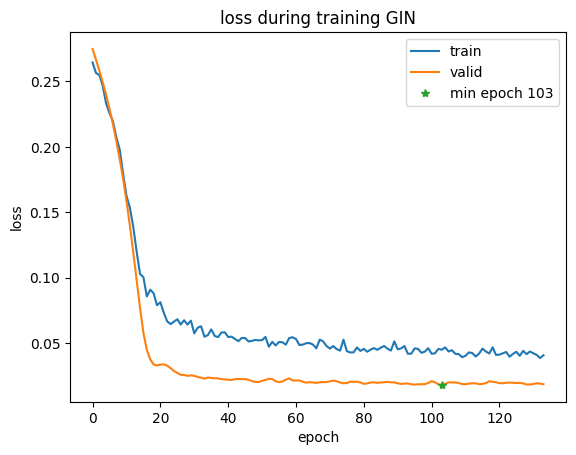

[Test] Loss: 0.018
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.454  &0.319  &0.565  &0.498


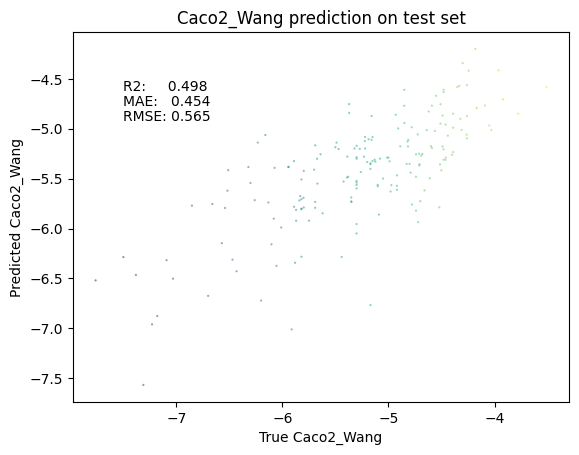

In [8]:
# model GIN on Caco2_Wang single task
config_path_LD50_GIN_SO = '/content/drive/MyDrive/ADMET/GIN/Caco2_Wang_ST.yml'
with open(config_path_LD50_GIN_SO, 'r') as f: data = yaml.safe_load(f)
config = data['config']
model_type = config['model_type']
task_names = config['prop_names']
vocab = None if 'vocab' not in config else config['vocab']
trains, valids, tests = collect_data_10_27(task_names)
if config['scale_dict'] != None: # scale is done
    trains, valids, tests, dict_scale = scale(trains, valids, tests)
assert config['scale_dict'] == dict_scale
param_t = {'batch_size': batch_size, 'shuffle': False,
           'drop_last': False, 'num_workers': 0}
test_loader = get_loader(tests, task_names, param_t, model_type, vocab)
models = PRED(**config); models.load_status(data)
outputs = models.eval(test_loader, ver=True)

Found local copy...
Loading...
Done!


collect data for:  ['LD50_Zhu']
scaling train valid test data set for regression task 
--> preparing data loader for model type  GIN
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Pretrained model loaded
load pretrained model from  GIN/LD50_Zhu_ST.pt
finish load data status 

####################################################################
############################## CONFIG ##############################
####################################################################
IS_R : [True]
batch_size : 128
config_path : GIN/LD50_Zhu_ST.yml
dropout : 0.5
hid_dims : [128, 64, 16]
in_dim : 256
lr : 0.0001
model_path : GIN/LD50_Zhu_ST.pt
model_type : GIN
out_dim : 1
patience : 30
pretrain_model : gin_supervised_masking
prop_names : ['LD50_Zhu']
scale_dict : {'LD50_Zhu': [-0.3429999999999999, 10.207]}
verbose_freq : 20
wd : 1e-05
####################################################################
Pretrained model loaded
load pretrained model from  GIN/LD50_Zhu_ST.

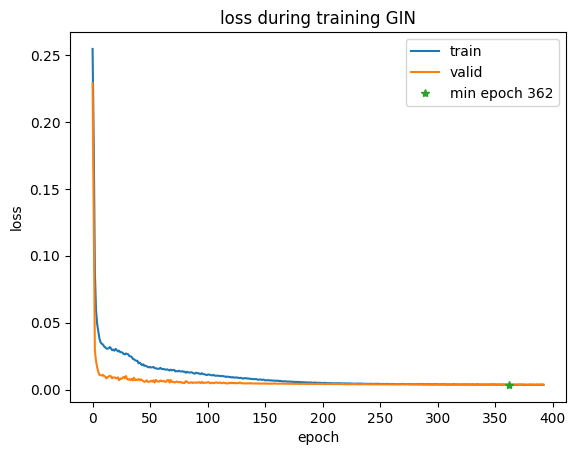

[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.433  &0.349  &0.591  &0.610


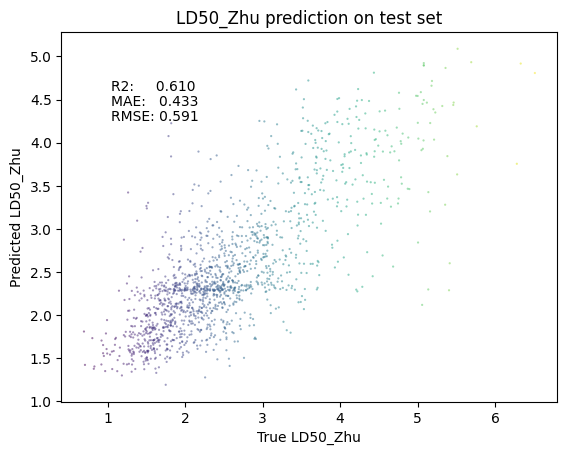

In [7]:
# model GIN on LD50 single task: best
config_path_LD50_GIN_SO = '/content/drive/MyDrive/ADMET/GIN/LD50_Zhu_ST.yml'
with open(config_path_LD50_GIN_SO, 'r') as f: data = yaml.safe_load(f)
config = data['config']
model_type = config['model_type']
task_names = config['prop_names']
vocab = None if 'vocab' not in config else config['vocab']
trains, valids, tests = collect_data_10_27(task_names)
if config['scale_dict'] != None: # scale is done
    trains, valids, tests, dict_scale = scale(trains, valids, tests)
assert config['scale_dict'] == dict_scale
param_t = {'batch_size': batch_size, 'shuffle': False,
           'drop_last': False, 'num_workers': 0}
test_loader = get_loader(tests, task_names, param_t, model_type, vocab)
models = PRED(**config); models.load_status(data)
outputs = models.eval(test_loader, ver=True)


In [25]:
config['scale_dict'], dict_scale

({'LD50_Zhu': [-0.3429999999999999, 10.207]},
 {'Caco2_Wang': [-7.7600002, -3.51]})

In [8]:
"""RESULTS"""
import yaml
for config_data_path, test_loader in zip(config_paths, test_loaders):
    with open(config_data_path, 'r') as f: data = yaml.safe_load(f)
    models = PRED(**data['config']); models.load_status(data)
    outputs = models.eval(test_loader, ver=False)

NameError: ignored

Found local copy...
Loading...
Done!


VOCAB TYPE:  smiles
collect data for:  ['CYP2C19_Veith']
---> loader for ['CYP2C19_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
Epoch:0, [Train] Loss: 0.686
Epoch:0, [Valid] Loss: 0.670
	 SAVE MODEL: loss: inf -> 0.670 | runtime: 1.189 ms
Epoch:1, [Train] Loss: 0.621
Epoch:1, [Valid] Loss: 0.603
	 SAVE MODEL: loss: 0.670 -> 0.603 | runtime: 1.206 ms
Epoch:2, [Train] Loss: 0.592
Epoch:2, [Valid] Loss: 0.590
	 SAVE MODEL: loss: 0.603 -> 0.590 | runtime: 1.178 ms
Epoch:3, [Train] Loss: 0.582
Epoch:3, [Valid] Loss: 0.585
	 SAVE MODEL: loss: 0.590 -> 0.585 | runtime: 1.218 ms
Epoch:4, [Train] Loss: 0.566
Epoch:4, [Valid] Loss: 0.564
	 SAVE MODEL: loss: 0.585 -> 0.564 | runtime: 1.238 ms
Epoch:5, [Train] Loss: 0.552
Epoch:5, [Valid] Loss: 0.549
	 SAVE MODEL: loss: 0.564 -> 0.549 | runtime: 1.258 ms
Epoch:6, [Train] Loss: 0.551
Epoch:6, [Valid] Los

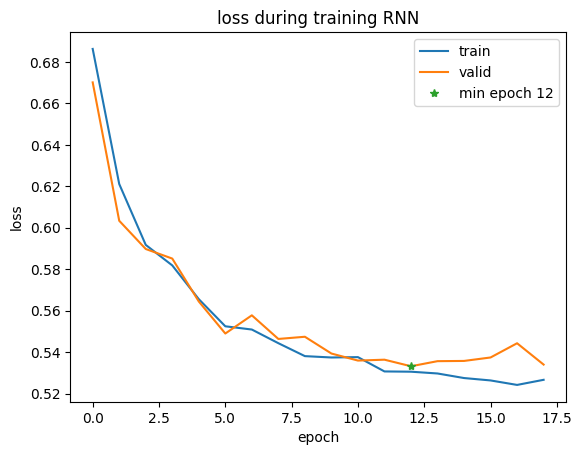


--> Train status saved at RNN/CYP2C19_Veith_ST.yml
Finished training
load pretrained model from  RNN/CYP2C19_Veith_ST.pt


Found local copy...
Loading...
Done!


[Test] Loss: 0.553
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.715  &  0.721  &          0.657  &     0.793  &0.649  &0.719 &0.793 &   0.443 &   0.727

collect data for:  ['CYP2D6_Veith']
---> loader for ['CYP2D6_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
Epoch:0, [Train] Loss: 0.525
Epoch:0, [Valid] Loss: 0.497
	 SAVE MODEL: loss: inf -> 0.497 | runtime: 1.203 ms
Epoch:1, [Train] Loss: 0.488
Epoch:1, [Valid] Loss: 0.501
EarlyStopping counter: 1 out of 5
Epoch:2, [Train] Loss: 0.464
Epoch:2, [Valid] Loss: 0.440
	 SAVE MODEL: loss: 0.497 -> 0.440 | runtime: 1.200 ms
Epoch:3, [Train] Loss: 0.428
Epoch:3, [Valid] Loss: 0.434
	 SAVE MODEL: loss: 0.440 -> 0.434 | runtime: 1.213 ms
Epoch:4, [Train] Loss: 0.420
Epoch:4, [Valid] Loss: 0.422
	 SAVE MODEL: 

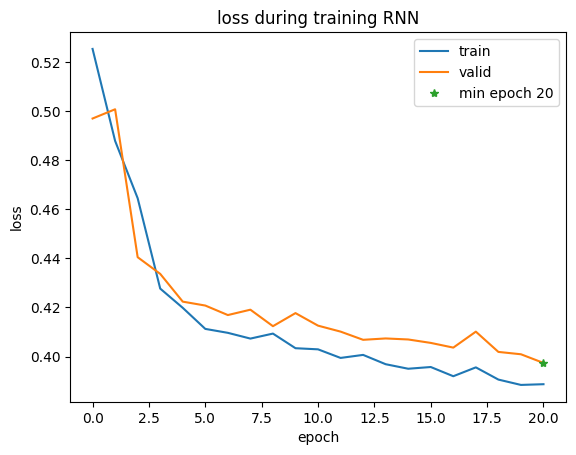

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.833  &  0.661  &          0.632  &     0.377  &0.946  &0.472 &0.798 &   0.399 &   0.532

Epoch:21, [Train] Loss: 0.390
Epoch:21, [Valid] Loss: 0.397
	 SAVE MODEL: loss: 0.397 -> 0.397 | runtime: 1.221 ms
Epoch:22, [Train] Loss: 0.385
Epoch:22, [Valid] Loss: 0.399
EarlyStopping counter: 1 out of 5
Epoch:23, [Train] Loss: 0.383
Epoch:23, [Valid] Loss: 0.401
EarlyStopping counter: 2 out of 5
Epoch:24, [Train] Loss: 0.383
Epoch:24, [Valid] Loss: 0.393
	 SAVE MODEL: loss: 0.397 -> 0.393 | runtime: 1.201 ms
Epoch:25, [Train] Loss: 0.382
Epoch:25, [Valid] Loss: 0.390
	 SAVE MODEL: loss: 0.393 -> 0.390 | runtime: 1.217 ms
Epoch:26, [Train] Loss: 0.381
Epoch:26, [Valid] Loss: 0.389
	 SAVE MODEL: loss: 0.390 -> 0.389 | runtime: 1.204 ms
Epoch:27, [Train] Loss: 0.381
Epoch:27, [Valid] Loss: 0.391
EarlyStopping counter: 1 out of 5
Epoch:28, [Train] Loss: 0.376
Ep

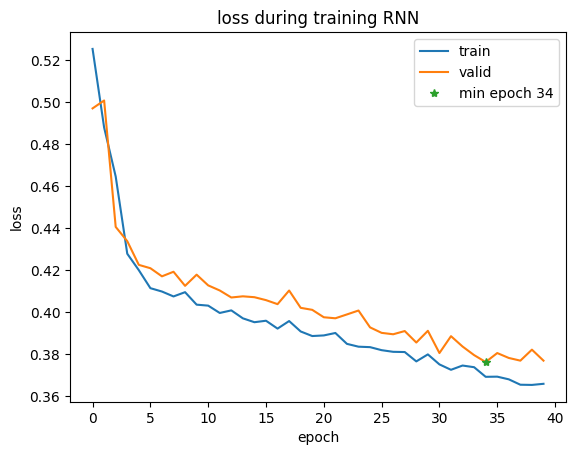


--> Train status saved at RNN/CYP2D6_Veith_ST.yml
Finished training
load pretrained model from  RNN/CYP2D6_Veith_ST.pt


Found local copy...
Loading...
Done!


[Test] Loss: 0.399
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.832  &  0.649  &          0.578  &     0.357  &0.941  &0.441 &0.780 &   0.363 &   0.508

collect data for:  ['CYP3A4_Veith']
---> loader for ['CYP3A4_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
Epoch:0, [Train] Loss: 0.675
Epoch:0, [Valid] Loss: 0.657
	 SAVE MODEL: loss: inf -> 0.657 | runtime: 1.158 ms
Epoch:1, [Train] Loss: 0.630
Epoch:1, [Valid] Loss: 0.585
	 SAVE MODEL: loss: 0.657 -> 0.585 | runtime: 1.161 ms
Epoch:2, [Train] Loss: 0.560
Epoch:2, [Valid] Loss: 0.585
	 SAVE MODEL: loss: 0.585 -> 0.585 | runtime: 1.167 ms
Epoch:3, [Train] Loss: 0.546
Epoch:3, [Valid] Loss: 0.572
	 SAVE MODEL: loss: 0.585 -> 0.572 | runtime: 1.168 ms
Epoch:4, [Train] Loss: 0.542
Epoch:4, [Valid] Loss: 

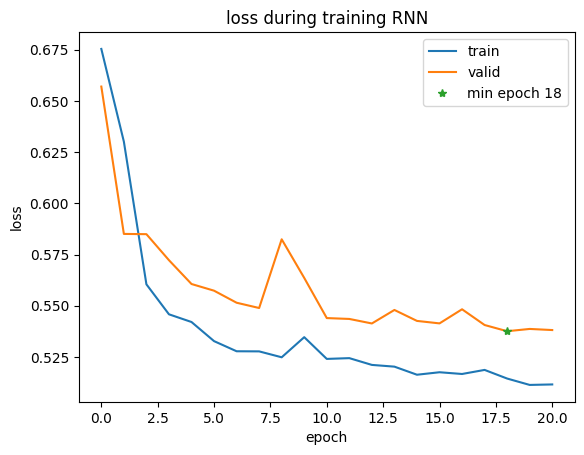

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.709  &  0.711  &          0.633  &     0.723  &0.699  &0.675 &0.788 &   0.416 &   0.673

Epoch:21, [Train] Loss: 0.512
Epoch:21, [Valid] Loss: 0.554
EarlyStopping counter: 3 out of 5
Epoch:22, [Train] Loss: 0.507
Epoch:22, [Valid] Loss: 0.537
	 SAVE MODEL: loss: 0.538 -> 0.537 | runtime: 1.182 ms
Epoch:23, [Train] Loss: 0.506
Epoch:23, [Valid] Loss: 0.534
	 SAVE MODEL: loss: 0.537 -> 0.534 | runtime: 1.200 ms
Epoch:24, [Train] Loss: 0.507
Epoch:24, [Valid] Loss: 0.534
	 SAVE MODEL: loss: 0.534 -> 0.534 | runtime: 1.153 ms
Epoch:25, [Train] Loss: 0.503
Epoch:25, [Valid] Loss: 0.549
EarlyStopping counter: 1 out of 5
Epoch:26, [Train] Loss: 0.505
Epoch:26, [Valid] Loss: 0.537
EarlyStopping counter: 2 out of 5
Epoch:27, [Train] Loss: 0.503
Epoch:27, [Valid] Loss: 0.533
	 SAVE MODEL: loss: 0.534 -> 0.533 | runtime: 1.168 ms
Epoch:28, [Train] Loss: 0.498
Ep

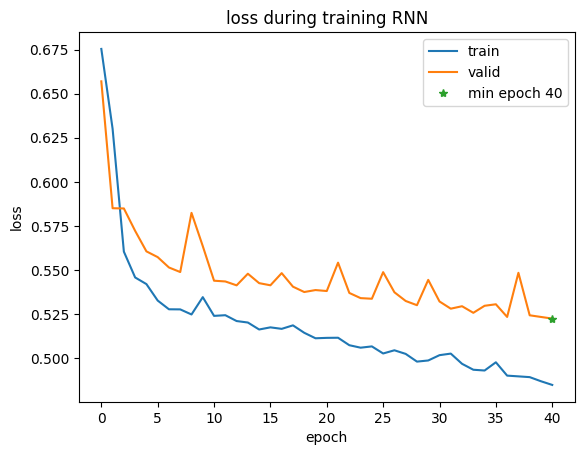

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.725  &  0.725  &          0.656  &     0.723  &0.727  &0.688 &0.809 &   0.445 &   0.731

Epoch:41, [Train] Loss: 0.484
Epoch:41, [Valid] Loss: 0.515
	 SAVE MODEL: loss: 0.523 -> 0.515 | runtime: 1.167 ms
Epoch:42, [Train] Loss: 0.483
Epoch:42, [Valid] Loss: 0.521
EarlyStopping counter: 1 out of 5
Epoch:43, [Train] Loss: 0.488
Epoch:43, [Valid] Loss: 0.517
EarlyStopping counter: 2 out of 5
Epoch:44, [Train] Loss: 0.483
Epoch:44, [Valid] Loss: 0.525
EarlyStopping counter: 3 out of 5
Epoch:45, [Train] Loss: 0.482
Epoch:45, [Valid] Loss: 0.516
EarlyStopping counter: 4 out of 5
Epoch:46, [Train] Loss: 0.480
Epoch:46, [Valid] Loss: 0.522
EarlyStopping counter: 5 out of 5
early stop
Model parameters:  3046533
Train time: 1.169+/-0.014 ms
best epoch: 41, min loss: 0.5147


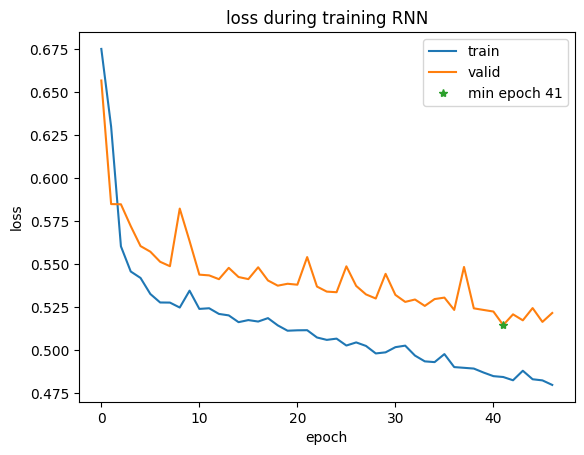


--> Train status saved at RNN/CYP3A4_Veith_ST.yml
Finished training
load pretrained model from  RNN/CYP3A4_Veith_ST.pt


Found local copy...
Loading...
Done!


[Test] Loss: 0.520
*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.734  &  0.718  &          0.698  &     0.625  &0.810  &0.660 &0.811 &   0.444 &   0.723

collect data for:  ['CYP1A2_Veith']
---> loader for ['CYP1A2_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
Epoch:0, [Train] Loss: 0.669
Epoch:0, [Valid] Loss: 0.558
	 SAVE MODEL: loss: inf -> 0.558 | runtime: 1.199 ms
Epoch:1, [Train] Loss: 0.528
Epoch:1, [Valid] Loss: 0.523
	 SAVE MODEL: loss: 0.558 -> 0.523 | runtime: 1.225 ms
Epoch:2, [Train] Loss: 0.512
Epoch:2, [Valid] Loss: 0.523
	 SAVE MODEL: loss: 0.523 -> 0.523 | runtime: 1.191 ms
Epoch:3, [Train] Loss: 0.502
Epoch:3, [Valid] Loss: 0.504
	 SAVE MODEL: loss: 0.523 -> 0.504 | runtime: 1.197 ms
Epoch:4, [Train] Loss: 0.498
Epoch:4, [Valid] Loss: 

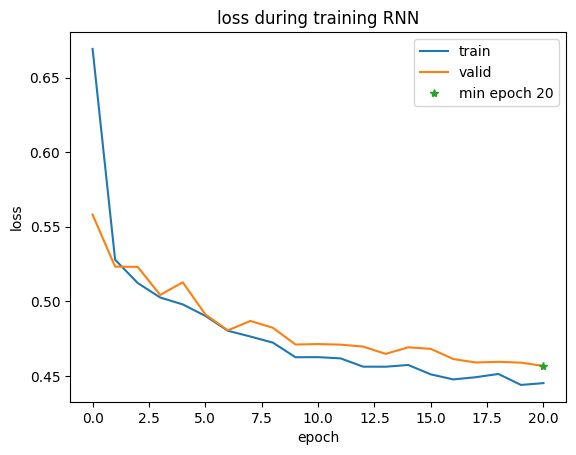

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.793  &  0.790  &          0.794  &     0.745  &0.835  &0.769 &0.868 &   0.583 &   0.842

Epoch:21, [Train] Loss: 0.439
Epoch:21, [Valid] Loss: 0.461
EarlyStopping counter: 1 out of 5
Epoch:22, [Train] Loss: 0.441
Epoch:22, [Valid] Loss: 0.455
	 SAVE MODEL: loss: 0.457 -> 0.455 | runtime: 1.181 ms
Epoch:23, [Train] Loss: 0.442
Epoch:23, [Valid] Loss: 0.454
	 SAVE MODEL: loss: 0.455 -> 0.454 | runtime: 1.182 ms
Epoch:24, [Train] Loss: 0.442
Epoch:24, [Valid] Loss: 0.455
EarlyStopping counter: 1 out of 5
Epoch:25, [Train] Loss: 0.435
Epoch:25, [Valid] Loss: 0.462
EarlyStopping counter: 2 out of 5
Epoch:26, [Train] Loss: 0.437
Epoch:26, [Valid] Loss: 0.458
EarlyStopping counter: 3 out of 5
Epoch:27, [Train] Loss: 0.434
Epoch:27, [Valid] Loss: 0.450
	 SAVE MODEL: loss: 0.454 -> 0.450 | runtime: 1.196 ms
Epoch:28, [Train] Loss: 0.429
Epoch:28, [Valid] Loss:

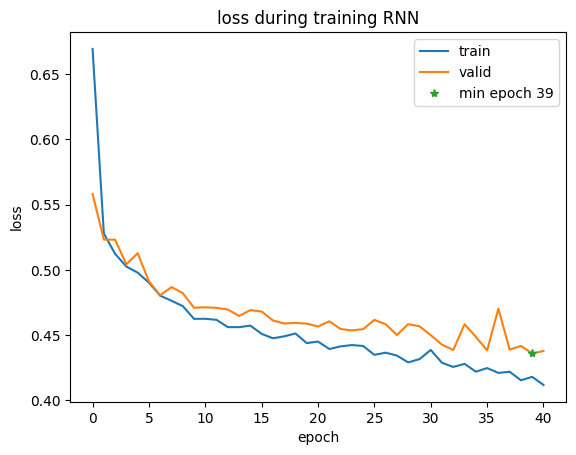

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.805  &  0.801  &          0.819  &     0.742  &0.860  &0.779 &0.884 &   0.608 &   0.856

Epoch:41, [Train] Loss: 0.413
Epoch:41, [Valid] Loss: 0.436
EarlyStopping counter: 2 out of 5
Epoch:42, [Train] Loss: 0.414
Epoch:42, [Valid] Loss: 0.436
	 SAVE MODEL: loss: 0.436 -> 0.436 | runtime: 1.182 ms
Epoch:43, [Train] Loss: 0.412
Epoch:43, [Valid] Loss: 0.432
	 SAVE MODEL: loss: 0.436 -> 0.432 | runtime: 1.201 ms
Epoch:44, [Train] Loss: 0.406
Epoch:44, [Valid] Loss: 0.431
	 SAVE MODEL: loss: 0.432 -> 0.431 | runtime: 1.166 ms
Epoch:45, [Train] Loss: 0.408
Epoch:45, [Valid] Loss: 0.453
EarlyStopping counter: 1 out of 5
Epoch:46, [Train] Loss: 0.408
Epoch:46, [Valid] Loss: 0.426
	 SAVE MODEL: loss: 0.431 -> 0.426 | runtime: 1.186 ms
Epoch:47, [Train] Loss: 0.407
Epoch:47, [Valid] Loss: 0.442
EarlyStopping counter: 1 out of 5
Epoch:48, [Train] Loss: 0.405
Ep

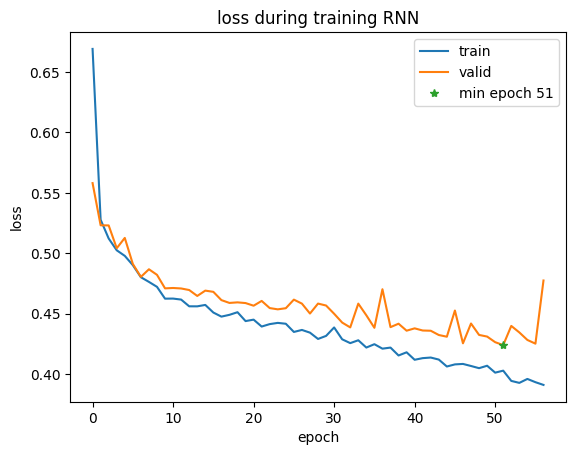


--> Train status saved at RNN/CYP1A2_Veith_ST.yml
Finished training
load pretrained model from  RNN/CYP1A2_Veith_ST.pt


Found local copy...
Loading...
Done!


[Test] Loss: 0.394
*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.822  &  0.821  &          0.818  &     0.801  &0.841  &0.809 &0.903 &   0.642 &   0.887

collect data for:  ['CYP2C9_Veith']
---> loader for ['CYP2C9_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
Model type:  RNN | Model parameters:  3046533
Epoch:0, [Train] Loss: 0.642
Epoch:0, [Valid] Loss: 0.643
	 SAVE MODEL: loss: inf -> 0.643 | runtime: 1.179 ms
Epoch:1, [Train] Loss: 0.622
Epoch:1, [Valid] Loss: 0.629
	 SAVE MODEL: loss: 0.643 -> 0.629 | runtime: 1.155 ms
Epoch:2, [Train] Loss: 0.546
Epoch:2, [Valid] Loss: 0.544
	 SAVE MODEL: loss: 0.629 -> 0.544 | runtime: 1.158 ms
Epoch:3, [Train] Loss: 0.525
Epoch:3, [Valid] Loss: 0.529
	 SAVE MODEL: loss: 0.544 -> 0.529 | runtime: 1.130 ms
Epoch:4, [Train] Loss: 0.511
Epoch:4, [Valid] Loss: 

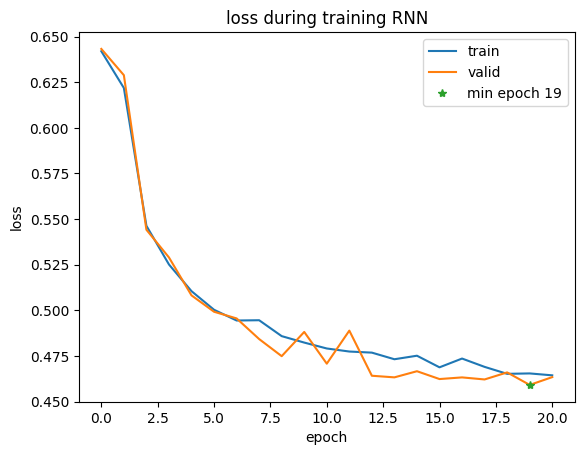

*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.781  &  0.762  &          0.671  &     0.705  &0.820  &0.687 &0.844 &   0.519 &   0.727

Epoch:21, [Train] Loss: 0.464
Epoch:21, [Valid] Loss: 0.455
	 SAVE MODEL: loss: 0.459 -> 0.455 | runtime: 1.160 ms
Epoch:22, [Train] Loss: 0.465
Epoch:22, [Valid] Loss: 0.460
EarlyStopping counter: 1 out of 5
Epoch:23, [Train] Loss: 0.461
Epoch:23, [Valid] Loss: 0.459
EarlyStopping counter: 2 out of 5
Epoch:24, [Train] Loss: 0.463
Epoch:24, [Valid] Loss: 0.460
EarlyStopping counter: 3 out of 5
Epoch:25, [Train] Loss: 0.462
Epoch:25, [Valid] Loss: 0.456
EarlyStopping counter: 4 out of 5
Epoch:26, [Train] Loss: 0.462
Epoch:26, [Valid] Loss: 0.459
EarlyStopping counter: 5 out of 5
early stop
Model parameters:  3046533
Train time: 1.150+/-0.014 ms
best epoch: 21, min loss: 0.4553


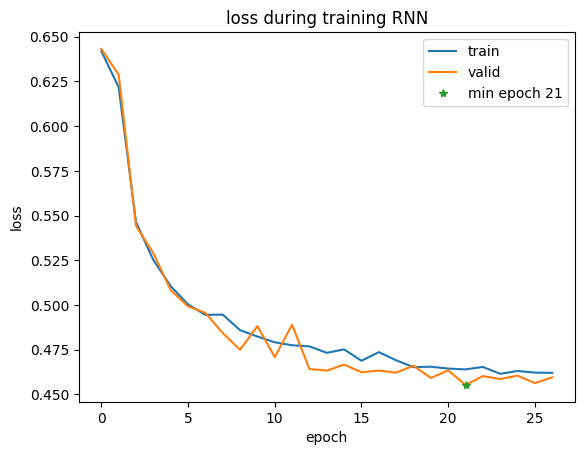


--> Train status saved at RNN/CYP2C9_Veith_ST.yml
Finished training
load pretrained model from  RNN/CYP2C9_Veith_ST.pt
[Test] Loss: 0.462
*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.773  &  0.727  &          0.698  &     0.582  &0.871  &0.635 &0.841 &   0.477 &   0.706

early_stop_2023-10-28_20-21-31.pth removed from /content/drive/MyDrive/ADMET/
early_stop_2023-10-28_20-24-59.pth removed from /content/drive/MyDrive/ADMET/
early_stop_2023-10-28_20-32-49.pth removed from /content/drive/MyDrive/ADMET/
early_stop_2023-10-28_20-41-12.pth removed from /content/drive/MyDrive/ADMET/
gin_supervised_infomax_pre_trained.pth removed from /content/drive/MyDrive/ADMET/
early_stop_2023-10-28_20-49-20.pth removed from /content/drive/MyDrive/ADMET/
early_stop_2023-10-28_20-50-26.pth removed from /content/drive/MyDrive/ADMET/
early_stop_2023-10-28_20-51-50.pth removed from /content/drive/MyDrive/ADMET/
early_s

Model type:  RNN | Model parameters:  3046533
load pretrained model from  RNN/CYP2C19_Veith_ST.pt
finish load data status 

[Test] Loss: 0.553
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.722  &  0.727  &          0.667  &     0.788  &0.666  &0.723 &0.791 &   0.455 &   0.719

Model type:  RNN | Model parameters:  3046533
load pretrained model from  RNN/CYP2D6_Veith_ST.pt
finish load data status 

[Test] Loss: 0.413
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.819  &  0.626  &          0.520  &     0.320  &0.933  &0.396 &0.761 &   0.309 &   0.452

Model type:  RNN | Model parameters:  3046533
load pretrained model from  RNN/CYP3A4_Veith_ST.pt
finish load data status 

[Test] Loss: 0.562
*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,    

In [ ]:
# config_paths

['RNN/CYP2C19_Veith_smi_ST.yml',
 'RNN/CYP2D6_Veith_smi_ST.yml',
 'RNN/CYP3A4_Veith_smi_ST.yml',
 'RNN/CYP1A2_Veith_smi_ST.yml',
 'RNN/CYP2C9_Veith_smi_ST.yml']

In [ ]:
# test_loader = get_loader(tests,  names, param_t, model_type, vocab)

In [ ]:
# import yaml
# with open('ckpt_RNN.yml', 'r') as f: data = yaml.safe_load(f)
# models = PRED(**data['config']); models.load_status(data)
# outputs = models.eval(test_l, ver=True)

Model type:  RNN | Model parameters:  2989073
load pretrained model from  ckpt_RNN.pt
finish load data status 



NameError: ignored

load pretrained model from  ckpt_MLP.pt
finish load data status 





####################################################################
############################## CONFIG ##############################
####################################################################
IS_R : [False]
batch_size : 128
config_path : ckpt_MLP.yml
dropout : 0.1
hid_dims : [128, 64, 16]
in_dim : 167
lr : 0.001
model_path : ckpt_MLP.pt
model_type : MLP
out_dim : 1
patience : 2
prop_names : ['CYP2C19_Veith']
scale_dict : None
verbose_freq : 20
wd : 1e-05
####################################################################
Model parameters:  30817
Train time: 0.188+/-0.087 ms
best epoch: 8, min loss: 0.4709


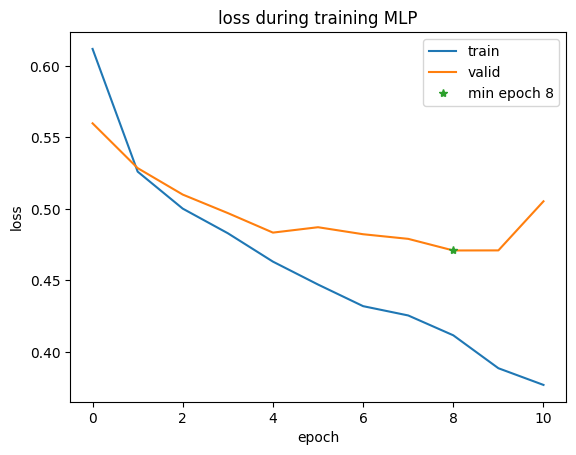

[Test] Loss: 0.489
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.774  &  0.771  &          0.765  &     0.733  &0.809  &0.748 &0.847 &   0.543 &   0.807



Found local copy...
Loading...
Done!


collect data for:  ['Caco2_Wang']
train: 637 | valid: 91 | test: 182 | total: 910
Alphabet:None



---> loader for ['Caco2_Wang']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 40
path: RNN/ is created
Model type:  RNN | Model parameters:  2956353
Epoch:0, [Train] Loss: 25.211
Epoch:0, [Valid] Loss: 16.561
	SAVE MODEL: loss: inf -> 16.561 | runtime: 1.576 ms
Epoch:1, [Train] Loss: 7.904
Epoch:1, [Valid] Loss: 3.535
	SAVE MODEL: loss: 16.561 -> 3.535 | runtime: 1.470 ms
Epoch:2, [Train] Loss: 3.918
Epoch:2, [Valid] Loss: 1.129
	SAVE MODEL: loss: 3.535 -> 1.129 | runtime: 1.462 ms
Epoch:3, [Train] Loss: 0.985
Epoch:3, [Valid] Loss: 1.430
EarlyStopping counter: 1 out of 20
Epoch:4, [Train] Loss: 1.553
Epoch:4, [Valid] Loss: 0.569
	SAVE MODEL: loss: 1.129 -> 0.569 | runtime: 1.495 ms
Epoch:5, [Train] Loss: 0.710
Epoch:5, [Valid]

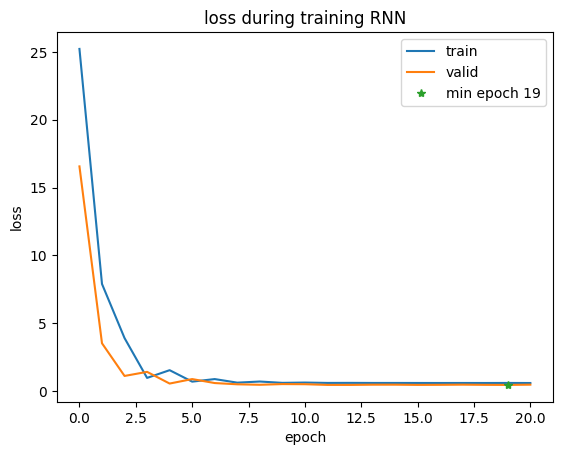

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.589  &0.487  &0.698  &-0.047

Epoch:21, [Train] Loss: 0.609
Epoch:21, [Valid] Loss: 0.475
EarlyStopping counter: 2 out of 20
Epoch:22, [Train] Loss: 0.607
Epoch:22, [Valid] Loss: 0.470
EarlyStopping counter: 3 out of 20
Epoch:23, [Train] Loss: 0.605
Epoch:23, [Valid] Loss: 0.473
EarlyStopping counter: 4 out of 20
Epoch:24, [Train] Loss: 0.603
Epoch:24, [Valid] Loss: 0.471
EarlyStopping counter: 5 out of 20
Epoch:25, [Train] Loss: 0.605
Epoch:25, [Valid] Loss: 0.468
	SAVE MODEL: loss: 0.468 -> 0.468 | runtime: 1.494 ms
Epoch:26, [Train] Loss: 0.603
Epoch:26, [Valid] Loss: 0.483
EarlyStopping counter: 1 out of 20
Epoch:27, [Train] Loss: 0.598
Epoch:27, [Valid] Loss: 0.464
	SAVE MODEL: loss: 0.468 -> 0.464 | runtime: 1.396 ms
Epoch:28, [Train] Loss: 0.596
Epoch:28, [Valid] Loss: 0.464
	SAVE MODEL: loss: 0.464 -> 0.464 | runtime: 1.488 ms
Epoch:29, [Train] Loss: 0.593
Epoch:29, [Valid] Loss: 0.471
EarlyStopping coun

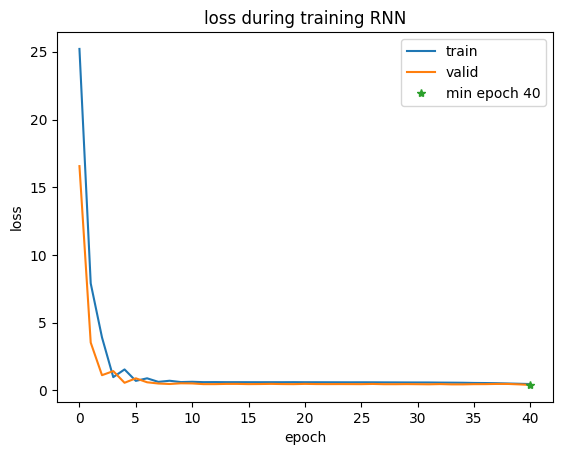

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.530  &0.411  &0.641  &0.118

Epoch:41, [Train] Loss: 0.471
Epoch:41, [Valid] Loss: 0.411
	SAVE MODEL: loss: 0.411 -> 0.411 | runtime: 1.373 ms
Epoch:42, [Train] Loss: 0.469
Epoch:42, [Valid] Loss: 0.448
EarlyStopping counter: 1 out of 20
Epoch:43, [Train] Loss: 0.466
Epoch:43, [Valid] Loss: 0.407
	SAVE MODEL: loss: 0.411 -> 0.407 | runtime: 1.482 ms
Epoch:44, [Train] Loss: 0.454
Epoch:44, [Valid] Loss: 0.402
	SAVE MODEL: loss: 0.407 -> 0.402 | runtime: 1.378 ms
Epoch:45, [Train] Loss: 0.453
Epoch:45, [Valid] Loss: 0.418
EarlyStopping counter: 1 out of 20
Epoch:46, [Train] Loss: 0.437
Epoch:46, [Valid] Loss: 0.396
	SAVE MODEL: loss: 0.402 -> 0.396 | runtime: 1.482 ms
Epoch:47, [Train] Loss: 0.430
Epoch:47, [Valid] Loss: 0.402
EarlyStopping counter: 1 out of 20
Epoch:48, [Train] Loss: 0.429
Epoch:48, [Valid] Loss: 0.389
	SAVE MODEL: loss: 0.396 -> 0.389 | runtime: 1.369 ms
Epoch:49, [Train] Loss: 0.425
Epoch:49, [

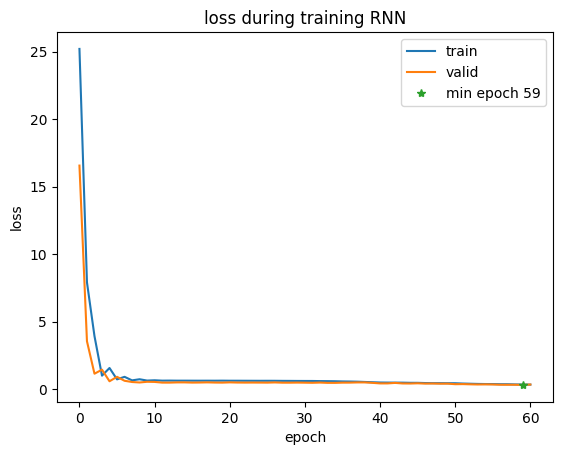

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.449  &0.327  &0.571  &0.299

Epoch:61, [Train] Loss: 0.315
Epoch:61, [Valid] Loss: 0.284
	SAVE MODEL: loss: 0.298 -> 0.284 | runtime: 1.479 ms
Epoch:62, [Train] Loss: 0.310
Epoch:62, [Valid] Loss: 0.303
EarlyStopping counter: 1 out of 20
Epoch:63, [Train] Loss: 0.323
Epoch:63, [Valid] Loss: 0.293
EarlyStopping counter: 2 out of 20
Epoch:64, [Train] Loss: 0.311
Epoch:64, [Valid] Loss: 0.295
EarlyStopping counter: 3 out of 20
Epoch:65, [Train] Loss: 0.302
Epoch:65, [Valid] Loss: 0.311
EarlyStopping counter: 4 out of 20
Epoch:66, [Train] Loss: 0.306
Epoch:66, [Valid] Loss: 0.344
EarlyStopping counter: 5 out of 20
Epoch:67, [Train] Loss: 0.314
Epoch:67, [Valid] Loss: 0.360
EarlyStopping counter: 6 out of 20
Epoch:68, [Train] Loss: 0.343
Epoch:68, [Valid] Loss: 0.276
	SAVE MODEL: loss: 0.284 -> 0.276 | runtime: 1.373 ms
Epoch:69, [Train] Loss: 0.315
Epoch:69, [Valid] Loss: 0.303
EarlyStopping counter: 1 out of 20
Epo

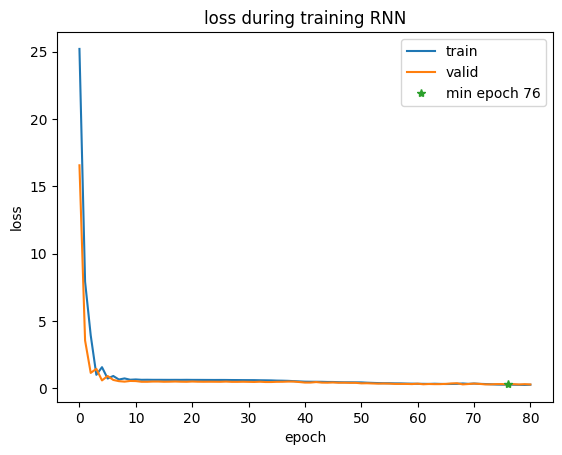

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.412  &0.269  &0.519  &0.422

Epoch:81, [Train] Loss: 0.240
Epoch:81, [Valid] Loss: 0.276
EarlyStopping counter: 5 out of 20
Epoch:82, [Train] Loss: 0.228
Epoch:82, [Valid] Loss: 0.268
EarlyStopping counter: 6 out of 20
Epoch:83, [Train] Loss: 0.225
Epoch:83, [Valid] Loss: 0.276
EarlyStopping counter: 7 out of 20
Epoch:84, [Train] Loss: 0.226
Epoch:84, [Valid] Loss: 0.273
EarlyStopping counter: 8 out of 20
Epoch:85, [Train] Loss: 0.222
Epoch:85, [Valid] Loss: 0.288
EarlyStopping counter: 9 out of 20
Epoch:86, [Train] Loss: 0.236
Epoch:86, [Valid] Loss: 0.296
EarlyStopping counter: 10 out of 20
Epoch:87, [Train] Loss: 0.221
Epoch:87, [Valid] Loss: 0.308
EarlyStopping counter: 11 out of 20
Epoch:88, [Train] Loss: 0.226
Epoch:88, [Valid] Loss: 0.293
EarlyStopping counter: 12 out of 20
Epoch:89, [Train] Loss: 0.226
Epoch:89, [Valid] Loss: 0.289
EarlyStopping counter: 13 out of 20
Epoch:90, [Train] Loss: 0.224
Epoch:9

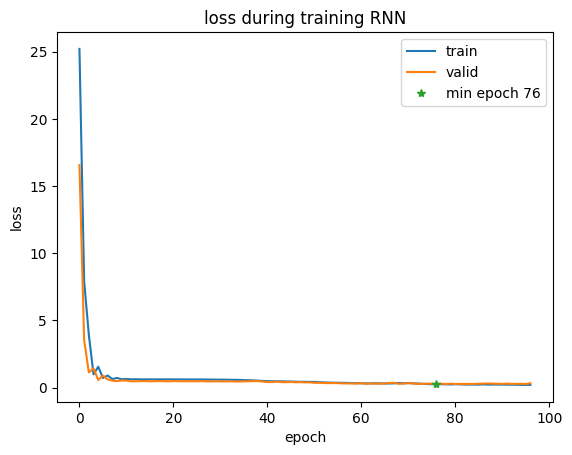

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'a', 'c', 'l', 'n', 'o', 'r', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['Caco2_Wang']
dropout : 0.1
IS_R : [True]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/Caco2_Wang_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/Caco2_Wang_char_ST.pt
[Test] Loss: 0.378
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.496  &0.378  &0.615  &0.404


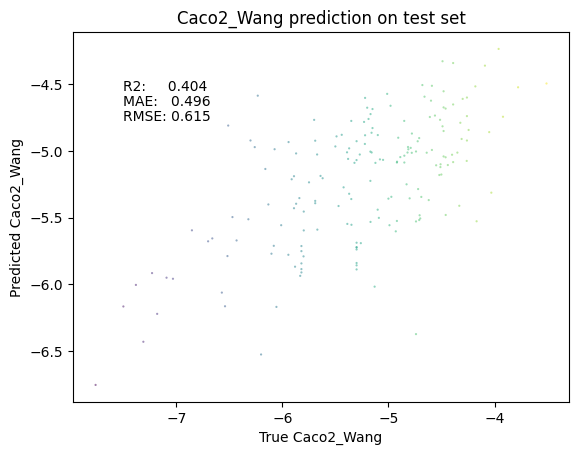

Found local copy...
Loading...
Done!



collect data for:  ['Lipophilicity_AstraZeneca']
train: 2940 | valid: 420 | test: 840 | total: 4200
Alphabet:None



---> loader for ['Lipophilicity_AstraZeneca']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 39
path: RNN/ already exists
Model type:  RNN | Model parameters:  2954738
Epoch:0, [Train] Loss: 2.411
Epoch:0, [Valid] Loss: 1.589
	SAVE MODEL: loss: inf -> 1.589 | runtime: 0.851 ms
Epoch:1, [Train] Loss: 1.489
Epoch:1, [Valid] Loss: 1.444
	SAVE MODEL: loss: 1.589 -> 1.444 | runtime: 0.877 ms
Epoch:2, [Train] Loss: 1.453
Epoch:2, [Valid] Loss: 1.451
EarlyStopping counter: 1 out of 20
Epoch:3, [Train] Loss: 1.440
Epoch:3, [Valid] Loss: 1.437
	SAVE MODEL: loss: 1.444 -> 1.437 | runtime: 0.858 ms
Epoch:4, [Train] Loss: 1.426
Epoch:4, [Valid] Loss: 1.457
EarlyStopping counter: 1 out of 20
Epoch:5, [Train] Loss: 1.406
E

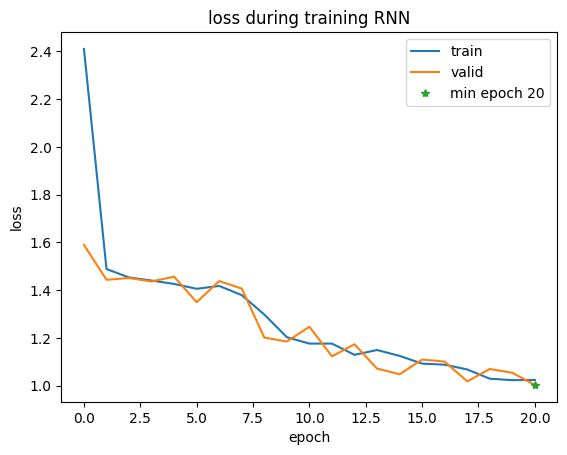

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.808  &1.003  &1.002  &0.302

Epoch:21, [Train] Loss: 1.008
Epoch:21, [Valid] Loss: 1.048
EarlyStopping counter: 1 out of 20
Epoch:22, [Train] Loss: 0.974
Epoch:22, [Valid] Loss: 0.924
	SAVE MODEL: loss: 1.003 -> 0.924 | runtime: 0.849 ms
Epoch:23, [Train] Loss: 0.927
Epoch:23, [Valid] Loss: 0.902
	SAVE MODEL: loss: 0.924 -> 0.902 | runtime: 0.856 ms
Epoch:24, [Train] Loss: 0.960
Epoch:24, [Valid] Loss: 0.966
EarlyStopping counter: 1 out of 20
Epoch:25, [Train] Loss: 0.881
Epoch:25, [Valid] Loss: 0.906
EarlyStopping counter: 2 out of 20
Epoch:26, [Train] Loss: 0.843
Epoch:26, [Valid] Loss: 0.858
	SAVE MODEL: loss: 0.902 -> 0.858 | runtime: 0.876 ms
Epoch:27, [Train] Loss: 0.800
Epoch:27, [Valid] Loss: 0.934
EarlyStopping counter: 1 out of 20
Epoch:28, [Train] Loss: 0.846
Epoch:28, [Valid] Loss: 0.855
	SAVE MODEL: loss: 0.858 -> 0.855 | runtime: 0.844 ms
Epoch:29, [Train] Loss: 0.791
Epoch:29, [Vali

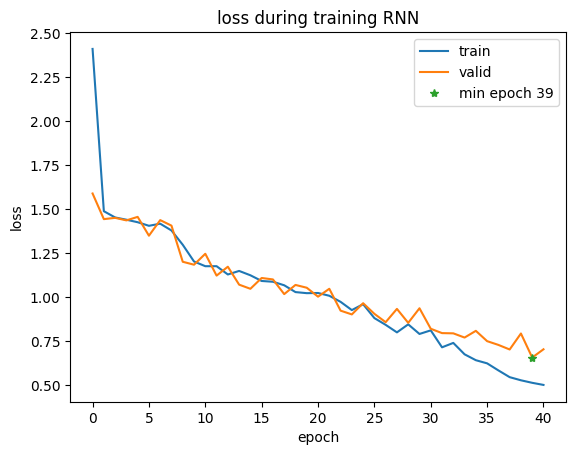

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.648  &0.704  &0.839  &0.510

Epoch:41, [Train] Loss: 0.463
Epoch:41, [Valid] Loss: 0.666
EarlyStopping counter: 2 out of 20
Epoch:42, [Train] Loss: 0.415
Epoch:42, [Valid] Loss: 0.709
EarlyStopping counter: 3 out of 20
Epoch:43, [Train] Loss: 0.402
Epoch:43, [Valid] Loss: 0.670
EarlyStopping counter: 4 out of 20
Epoch:44, [Train] Loss: 0.383
Epoch:44, [Valid] Loss: 0.676
EarlyStopping counter: 5 out of 20
Epoch:45, [Train] Loss: 0.362
Epoch:45, [Valid] Loss: 0.648
	SAVE MODEL: loss: 0.657 -> 0.648 | runtime: 0.858 ms
Epoch:46, [Train] Loss: 0.342
Epoch:46, [Valid] Loss: 0.658
EarlyStopping counter: 1 out of 20
Epoch:47, [Train] Loss: 0.327
Epoch:47, [Valid] Loss: 0.747
EarlyStopping counter: 2 out of 20
Epoch:48, [Train] Loss: 0.364
Epoch:48, [Valid] Loss: 0.660
EarlyStopping counter: 3 out of 20
Epoch:49, [Train] Loss: 0.358
Epoch:49, [Valid] Loss: 0.642
	SAVE MODEL: loss: 0.648 -> 0.642 | runtim

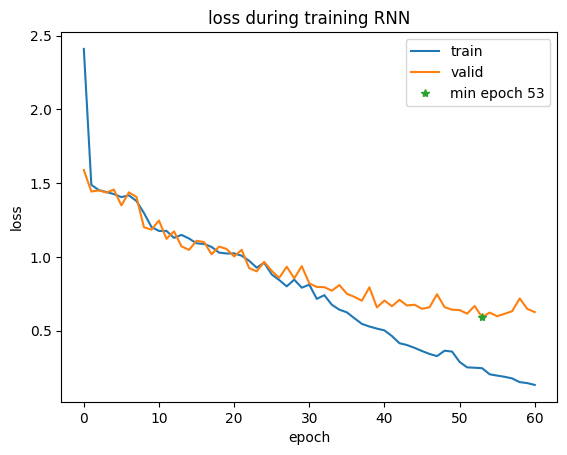

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.591  &0.626  &0.791  &0.565

Epoch:61, [Train] Loss: 0.128
Epoch:61, [Valid] Loss: 0.649
EarlyStopping counter: 8 out of 20
Epoch:62, [Train] Loss: 0.118
Epoch:62, [Valid] Loss: 0.642
EarlyStopping counter: 9 out of 20
Epoch:63, [Train] Loss: 0.108
Epoch:63, [Valid] Loss: 0.676
EarlyStopping counter: 10 out of 20
Epoch:64, [Train] Loss: 0.105
Epoch:64, [Valid] Loss: 0.648
EarlyStopping counter: 11 out of 20
Epoch:65, [Train] Loss: 0.094
Epoch:65, [Valid] Loss: 0.635
EarlyStopping counter: 12 out of 20
Epoch:66, [Train] Loss: 0.088
Epoch:66, [Valid] Loss: 0.674
EarlyStopping counter: 13 out of 20
Epoch:67, [Train] Loss: 0.086
Epoch:67, [Valid] Loss: 0.664
EarlyStopping counter: 14 out of 20
Epoch:68, [Train] Loss: 0.083
Epoch:68, [Valid] Loss: 0.660
EarlyStopping counter: 15 out of 20
Epoch:69, [Train] Loss: 0.081
Epoch:69, [Valid] Loss: 0.656
EarlyStopping counter: 16 out of 20
Epoch:70, [Train] L

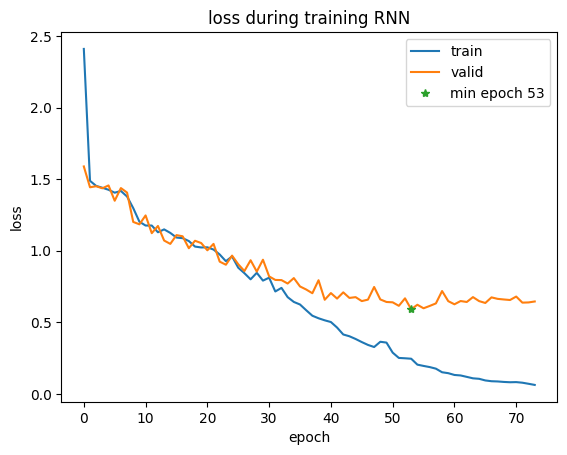

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'e', 'i', 'l', 'n', 'o', 'r', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['Lipophilicity_AstraZeneca']
dropout : 0.1
IS_R : [True]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/Lipophilicity_AstraZeneca_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/Lipophilicity_AstraZeneca_char_ST.pt
[Test] Loss: 0.714
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.624  &0.714  &0.845  &

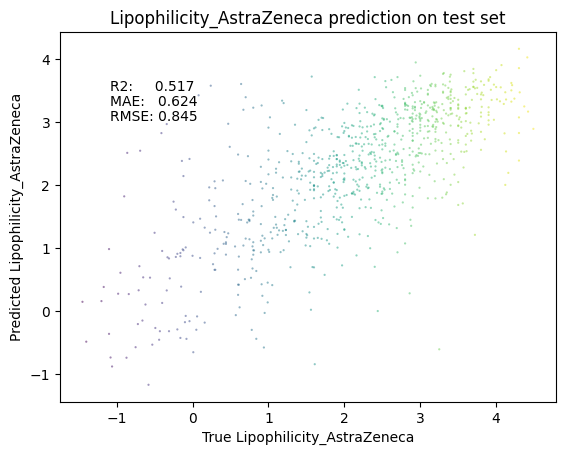

Found local copy...
Loading...
Done!



collect data for:  ['HydrationFreeEnergy_FreeSolv']
train: 450 | valid: 64 | test: 128 | total: 642
Alphabet:None



---> loader for ['HydrationFreeEnergy_FreeSolv']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 34
path: RNN/ already exists
Model type:  RNN | Model parameters:  2946693
Epoch:0, [Train] Loss: 29.209
Epoch:0, [Valid] Loss: 26.464
	SAVE MODEL: loss: inf -> 26.464 | runtime: 0.447 ms
Epoch:1, [Train] Loss: 23.736
Epoch:1, [Valid] Loss: 14.287
	SAVE MODEL: loss: 26.464 -> 14.287 | runtime: 0.503 ms
Epoch:2, [Train] Loss: 16.608
Epoch:2, [Valid] Loss: 13.394
	SAVE MODEL: loss: 14.287 -> 13.394 | runtime: 0.475 ms
Epoch:3, [Train] Loss: 16.113
Epoch:3, [Valid] Loss: 12.044
	SAVE MODEL: loss: 13.394 -> 12.044 | runtime: 0.473 ms
Epoch:4, [Train] Loss: 14.850
Epoch:4, [Valid] Loss: 13.465
EarlyStopping counter: 1 o

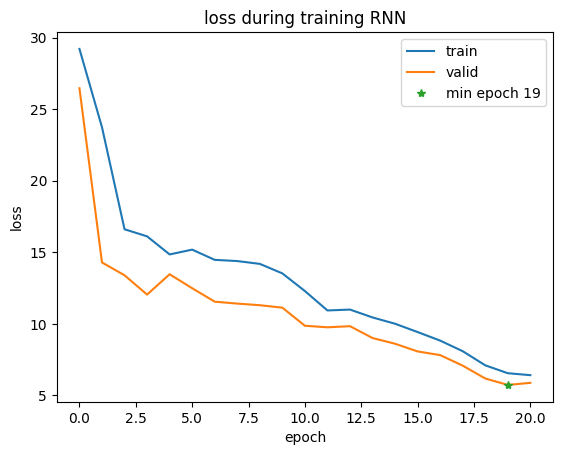

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.891  &5.877  &2.424  &0.501

Epoch:21, [Train] Loss: 6.025
Epoch:21, [Valid] Loss: 5.571
	SAVE MODEL: loss: 5.732 -> 5.571 | runtime: 0.448 ms
Epoch:22, [Train] Loss: 5.777
Epoch:22, [Valid] Loss: 5.419
	SAVE MODEL: loss: 5.571 -> 5.419 | runtime: 0.466 ms
Epoch:23, [Train] Loss: 5.614
Epoch:23, [Valid] Loss: 5.305
	SAVE MODEL: loss: 5.419 -> 5.305 | runtime: 0.474 ms
Epoch:24, [Train] Loss: 5.618
Epoch:24, [Valid] Loss: 5.362
EarlyStopping counter: 1 out of 20
Epoch:25, [Train] Loss: 5.398
Epoch:25, [Valid] Loss: 5.316
EarlyStopping counter: 2 out of 20
Epoch:26, [Train] Loss: 5.318
Epoch:26, [Valid] Loss: 5.029
	SAVE MODEL: loss: 5.305 -> 5.029 | runtime: 0.478 ms
Epoch:27, [Train] Loss: 4.934
Epoch:27, [Valid] Loss: 4.959
	SAVE MODEL: loss: 5.029 -> 4.959 | runtime: 0.451 ms
Epoch:28, [Train] Loss: 4.707
Epoch:28, [Valid] Loss: 4.804
	SAVE MODEL: loss: 4.959 -> 4.804 | runtime: 0.488 ms
Epoc

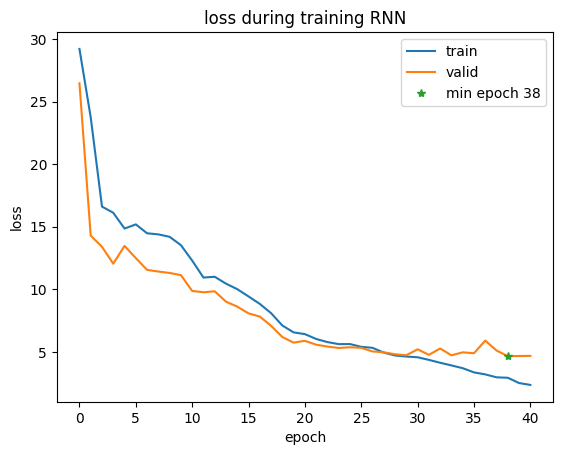

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.604  &4.674  &2.162  &0.604

Epoch:41, [Train] Loss: 2.210
Epoch:41, [Valid] Loss: 6.974
EarlyStopping counter: 3 out of 20
Epoch:42, [Train] Loss: 2.225
Epoch:42, [Valid] Loss: 6.465
EarlyStopping counter: 4 out of 20
Epoch:43, [Train] Loss: 2.115
Epoch:43, [Valid] Loss: 5.548
EarlyStopping counter: 5 out of 20
Epoch:44, [Train] Loss: 2.038
Epoch:44, [Valid] Loss: 5.781
EarlyStopping counter: 6 out of 20
Epoch:45, [Train] Loss: 2.027
Epoch:45, [Valid] Loss: 5.456
EarlyStopping counter: 7 out of 20
Epoch:46, [Train] Loss: 1.941
Epoch:46, [Valid] Loss: 4.716
EarlyStopping counter: 8 out of 20
Epoch:47, [Train] Loss: 1.905
Epoch:47, [Valid] Loss: 6.169
EarlyStopping counter: 9 out of 20
Epoch:48, [Train] Loss: 1.902
Epoch:48, [Valid] Loss: 4.527
	SAVE MODEL: loss: 4.652 -> 4.527 | runtime: 0.472 ms
Epoch:49, [Train] Loss: 1.816
Epoch:49, [Valid] Loss: 5.872
EarlyStopping counter: 1 out of 20
Epoc

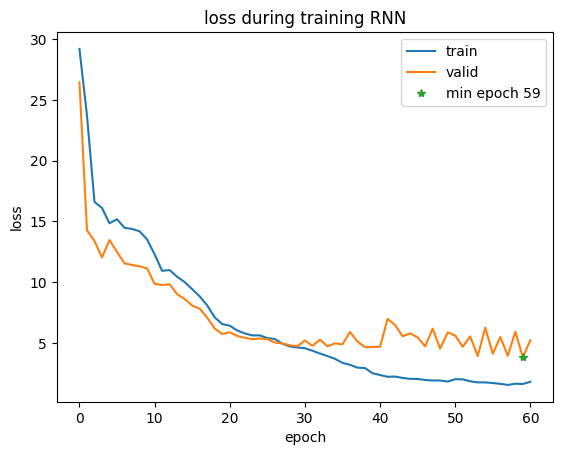

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.664  &5.214  &2.283  &0.558

Epoch:61, [Train] Loss: 1.746
Epoch:61, [Valid] Loss: 3.730
	SAVE MODEL: loss: 3.822 -> 3.730 | runtime: 0.506 ms
Epoch:62, [Train] Loss: 1.644
Epoch:62, [Valid] Loss: 4.968
EarlyStopping counter: 1 out of 20
Epoch:63, [Train] Loss: 1.441
Epoch:63, [Valid] Loss: 4.148
EarlyStopping counter: 2 out of 20
Epoch:64, [Train] Loss: 1.703
Epoch:64, [Valid] Loss: 5.393
EarlyStopping counter: 3 out of 20
Epoch:65, [Train] Loss: 1.463
Epoch:65, [Valid] Loss: 3.600
	SAVE MODEL: loss: 3.730 -> 3.600 | runtime: 0.499 ms
Epoch:66, [Train] Loss: 1.370
Epoch:66, [Valid] Loss: 5.048
EarlyStopping counter: 1 out of 20
Epoch:67, [Train] Loss: 1.231
Epoch:67, [Valid] Loss: 3.926
EarlyStopping counter: 2 out of 20
Epoch:68, [Train] Loss: 1.424
Epoch:68, [Valid] Loss: 4.647
EarlyStopping counter: 3 out of 20
Epoch:69, [Train] Loss: 1.246
Epoch:69, [Valid] Loss: 3.932
EarlyStopping counte

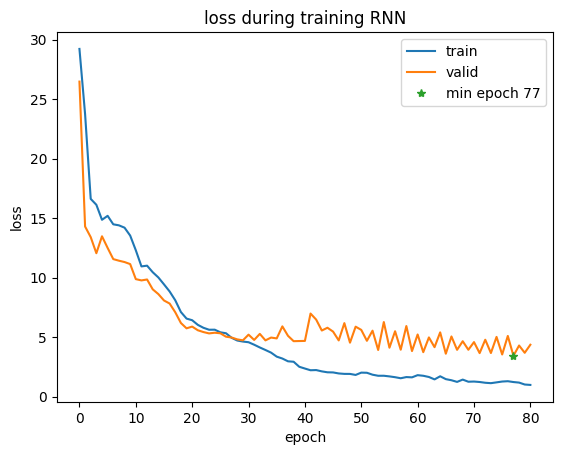

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.459  &4.353  &2.086  &0.631

Epoch:81, [Train] Loss: 0.941
Epoch:81, [Valid] Loss: 3.654
EarlyStopping counter: 4 out of 20
Epoch:82, [Train] Loss: 0.935
Epoch:82, [Valid] Loss: 3.954
EarlyStopping counter: 5 out of 20
Epoch:83, [Train] Loss: 0.911
Epoch:83, [Valid] Loss: 3.633
EarlyStopping counter: 6 out of 20
Epoch:84, [Train] Loss: 1.012
Epoch:84, [Valid] Loss: 4.182
EarlyStopping counter: 7 out of 20
Epoch:85, [Train] Loss: 0.901
Epoch:85, [Valid] Loss: 3.576
EarlyStopping counter: 8 out of 20
Epoch:86, [Train] Loss: 0.917
Epoch:86, [Valid] Loss: 4.194
EarlyStopping counter: 9 out of 20
Epoch:87, [Train] Loss: 0.927
Epoch:87, [Valid] Loss: 3.558
EarlyStopping counter: 10 out of 20
Epoch:88, [Train] Loss: 0.915
Epoch:88, [Valid] Loss: 4.366
EarlyStopping counter: 11 out of 20
Epoch:89, [Train] Loss: 0.889
Epoch:89, [Valid] Loss: 3.525
EarlyStopping counter: 12 out of 20
Epoch:90, [Train] Lo

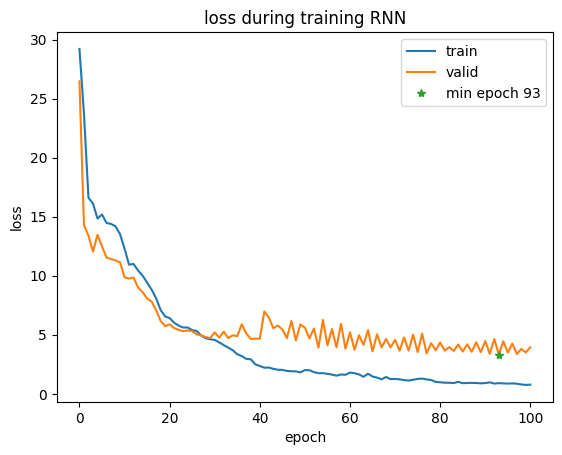

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.402  &3.943  &1.986  &0.666

Epoch:101, [Train] Loss: 0.738
Epoch:101, [Valid] Loss: 3.457
EarlyStopping counter: 8 out of 20
Epoch:102, [Train] Loss: 0.662
Epoch:102, [Valid] Loss: 3.737
EarlyStopping counter: 9 out of 20
Epoch:103, [Train] Loss: 0.674
Epoch:103, [Valid] Loss: 3.583
EarlyStopping counter: 10 out of 20
Epoch:104, [Train] Loss: 0.674
Epoch:104, [Valid] Loss: 3.750
EarlyStopping counter: 11 out of 20
Epoch:105, [Train] Loss: 0.655
Epoch:105, [Valid] Loss: 3.552
EarlyStopping counter: 12 out of 20
Epoch:106, [Train] Loss: 0.649
Epoch:106, [Valid] Loss: 3.802
EarlyStopping counter: 13 out of 20
Epoch:107, [Train] Loss: 0.633
Epoch:107, [Valid] Loss: 3.545
EarlyStopping counter: 14 out of 20
Epoch:108, [Train] Loss: 0.634
Epoch:108, [Valid] Loss: 3.786
EarlyStopping counter: 15 out of 20
Epoch:109, [Train] Loss: 0.561
Epoch:109, [Valid] Loss: 3.699
EarlyStopping counter: 16 out of 2

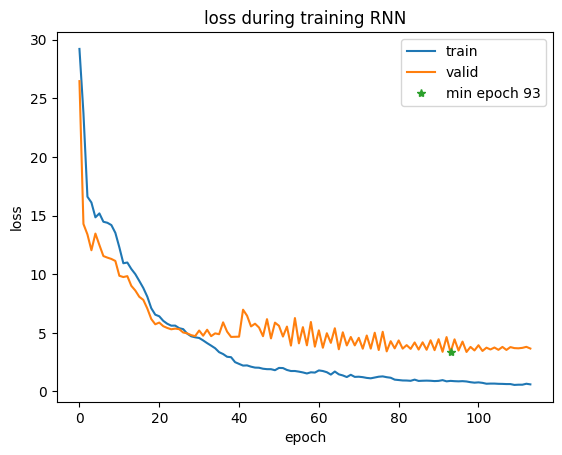

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'l', 'n', 'r', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['HydrationFreeEnergy_FreeSolv']
dropout : 0.1
IS_R : [True]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/HydrationFreeEnergy_FreeSolv_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/HydrationFreeEnergy_FreeSolv_char_ST.pt
[Test] Loss: 2.111
*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&1.163  &2.111  &1.453  &0.871


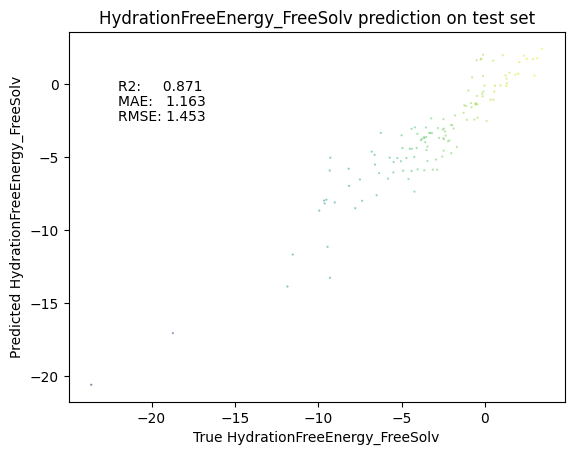

Found local copy...
Loading...
Done!



collect data for:  ['Solubility_AqSolDB']
train: 6988 | valid: 998 | test: 1996 | total: 9982
Alphabet:None



---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 65
path: RNN/ already exists
Model type:  RNN | Model parameters:  2997378
Epoch:0, [Train] Loss: 6.176
Epoch:0, [Valid] Loss: 3.115
	SAVE MODEL: loss: inf -> 3.115 | runtime: 1.308 ms
Epoch:1, [Train] Loss: 2.993
Epoch:1, [Valid] Loss: 2.536
	SAVE MODEL: loss: 3.115 -> 2.536 | runtime: 1.363 ms
Epoch:2, [Train] Loss: 2.757
Epoch:2, [Valid] Loss: 2.399
	SAVE MODEL: loss: 2.536 -> 2.399 | runtime: 1.326 ms
Epoch:3, [Train] Loss: 2.428
Epoch:3, [Valid] Loss: 2.201
	SAVE MODEL: loss: 2.399 -> 2.201 | runtime: 1.341 ms
Epoch:4, [Train] Loss: 2.192
Epoch:4, [Valid] Loss: 2.099
	SAVE MODEL: loss: 2.201 -> 2.099 | runtime: 1.330 ms
Epoch

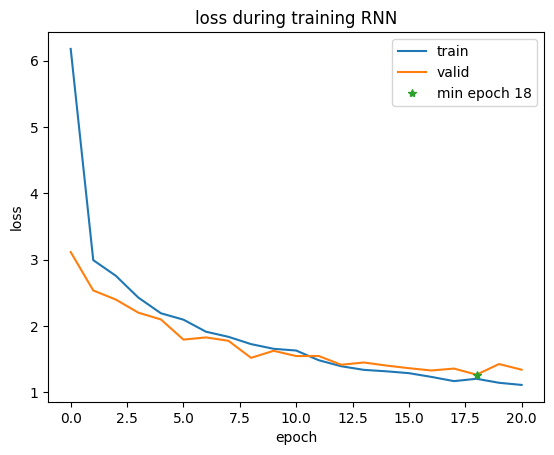

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.843  &1.342  &1.158  &0.747

Epoch:21, [Train] Loss: 1.077
Epoch:21, [Valid] Loss: 1.261
	SAVE MODEL: loss: 1.267 -> 1.261 | runtime: 1.365 ms
Epoch:22, [Train] Loss: 1.027
Epoch:22, [Valid] Loss: 1.313
EarlyStopping counter: 1 out of 20
Epoch:23, [Train] Loss: 0.992
Epoch:23, [Valid] Loss: 1.318
EarlyStopping counter: 2 out of 20
Epoch:24, [Train] Loss: 1.000
Epoch:24, [Valid] Loss: 1.287
EarlyStopping counter: 3 out of 20
Epoch:25, [Train] Loss: 1.002
Epoch:25, [Valid] Loss: 1.232
	SAVE MODEL: loss: 1.261 -> 1.232 | runtime: 1.351 ms
Epoch:26, [Train] Loss: 0.911
Epoch:26, [Valid] Loss: 1.153
	SAVE MODEL: loss: 1.232 -> 1.153 | runtime: 1.322 ms
Epoch:27, [Train] Loss: 0.905
Epoch:27, [Valid] Loss: 1.303
EarlyStopping counter: 1 out of 20
Epoch:28, [Train] Loss: 0.856
Epoch:28, [Valid] Loss: 1.213
EarlyStopping counter: 2 out of 20
Epoch:29, [Train] Loss: 0.844
Epoch:29, [Valid] Loss: 1.285
EarlyStoppi

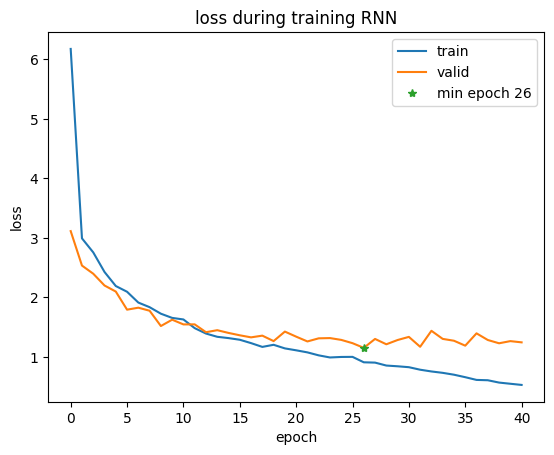

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.753  &1.246  &1.116  &0.765

Epoch:41, [Train] Loss: 0.521
Epoch:41, [Valid] Loss: 1.290
EarlyStopping counter: 15 out of 20
Epoch:42, [Train] Loss: 0.468
Epoch:42, [Valid] Loss: 1.230
EarlyStopping counter: 16 out of 20
Epoch:43, [Train] Loss: 0.402
Epoch:43, [Valid] Loss: 1.260
EarlyStopping counter: 17 out of 20
Epoch:44, [Train] Loss: 0.377
Epoch:44, [Valid] Loss: 1.262
EarlyStopping counter: 18 out of 20
Epoch:45, [Train] Loss: 0.362
Epoch:45, [Valid] Loss: 1.284
EarlyStopping counter: 19 out of 20
Epoch:46, [Train] Loss: 0.362
Epoch:46, [Valid] Loss: 1.228
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2997378
Train time: 1.336+/-0.020 ms
best epoch: 26, min loss: 1.1534


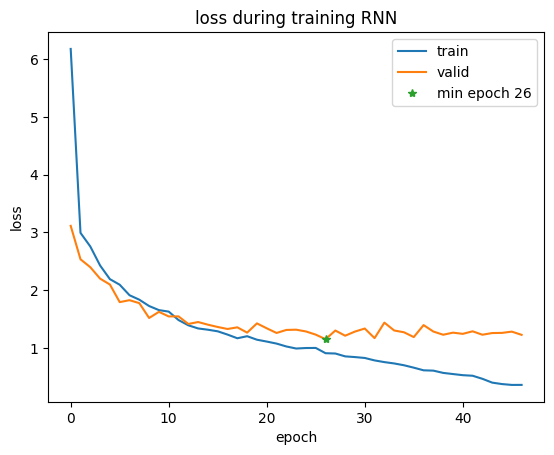

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V', 'W', 'Y', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'y']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['Solubility_AqSolDB']
dropout : 0.1
IS_R : [True]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/Solubility_AqSolDB_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/Solubility_AqSolDB_char_ST.pt
[Test] Loss: 1.213
***

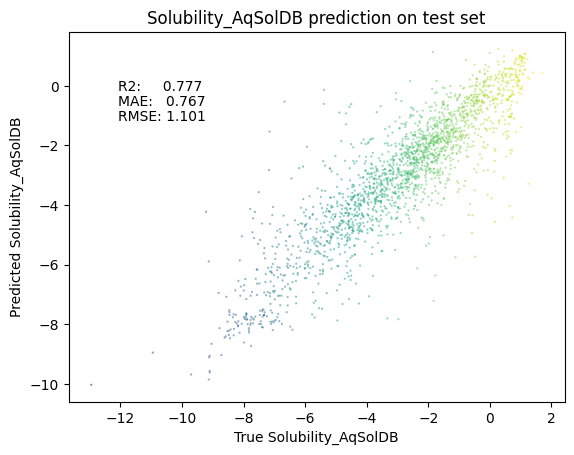

Found local copy...
Loading...
Done!



collect data for:  ['LD50_Zhu']
train: 5170 | valid: 738 | test: 1477 | total: 7385
Alphabet:None



---> loader for ['LD50_Zhu']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 36
path: RNN/ already exists
Model type:  RNN | Model parameters:  2949905
Epoch:0, [Train] Loss: 1.741
Epoch:0, [Valid] Loss: 0.984
	SAVE MODEL: loss: inf -> 0.984 | runtime: 0.740 ms
Epoch:1, [Train] Loss: 0.894
Epoch:1, [Valid] Loss: 0.891
	SAVE MODEL: loss: 0.984 -> 0.891 | runtime: 0.723 ms
Epoch:2, [Train] Loss: 0.730
Epoch:2, [Valid] Loss: 0.755
	SAVE MODEL: loss: 0.891 -> 0.755 | runtime: 0.737 ms
Epoch:3, [Train] Loss: 0.664
Epoch:3, [Valid] Loss: 0.672
	SAVE MODEL: loss: 0.755 -> 0.672 | runtime: 0.744 ms
Epoch:4, [Train] Loss: 0.647
Epoch:4, [Valid] Loss: 0.679
EarlyStopping counter: 1 out of 20
Epoch:5, [Train] Loss: 0.646
Epoch:5, [Valid

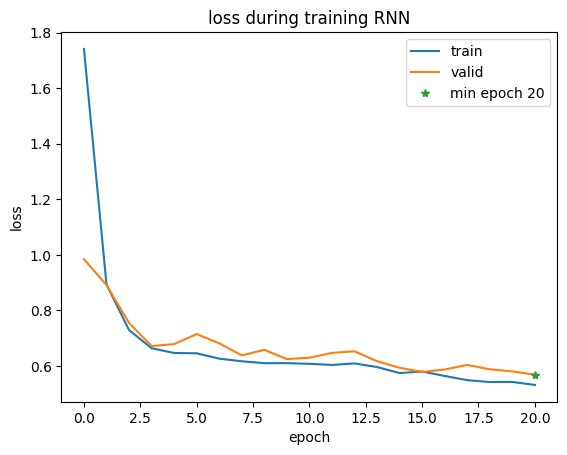

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.566  &0.569  &0.754  &0.405

Epoch:21, [Train] Loss: 0.531
Epoch:21, [Valid] Loss: 0.608
EarlyStopping counter: 1 out of 20
Epoch:22, [Train] Loss: 0.530
Epoch:22, [Valid] Loss: 0.574
EarlyStopping counter: 2 out of 20
Epoch:23, [Train] Loss: 0.538
Epoch:23, [Valid] Loss: 0.571
EarlyStopping counter: 3 out of 20
Epoch:24, [Train] Loss: 0.519
Epoch:24, [Valid] Loss: 0.599
EarlyStopping counter: 4 out of 20
Epoch:25, [Train] Loss: 0.520
Epoch:25, [Valid] Loss: 0.546
	SAVE MODEL: loss: 0.569 -> 0.546 | runtime: 0.736 ms
Epoch:26, [Train] Loss: 0.507
Epoch:26, [Valid] Loss: 0.538
	SAVE MODEL: loss: 0.546 -> 0.538 | runtime: 0.746 ms
Epoch:27, [Train] Loss: 0.496
Epoch:27, [Valid] Loss: 0.565
EarlyStopping counter: 1 out of 20
Epoch:28, [Train] Loss: 0.509
Epoch:28, [Valid] Loss: 0.563
EarlyStopping counter: 2 out of 20
Epoch:29, [Train] Loss: 0.495
Epoch:29, [Valid] Loss: 0.555
EarlyStopping counter: 3 out of 20
Epoch

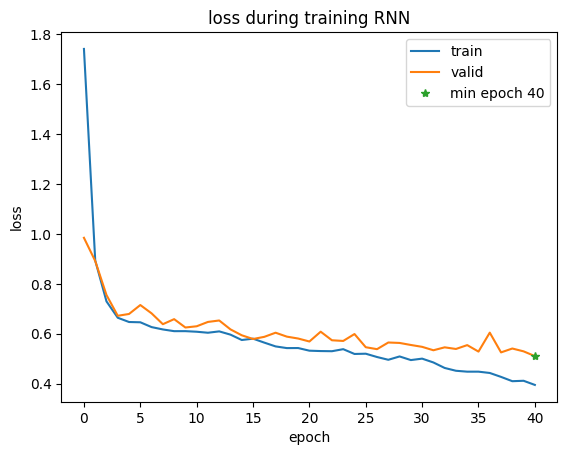

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.538  &0.510  &0.714  &0.467

Epoch:41, [Train] Loss: 0.385
Epoch:41, [Valid] Loss: 0.518
EarlyStopping counter: 1 out of 20
Epoch:42, [Train] Loss: 0.378
Epoch:42, [Valid] Loss: 0.525
EarlyStopping counter: 2 out of 20
Epoch:43, [Train] Loss: 0.355
Epoch:43, [Valid] Loss: 0.527
EarlyStopping counter: 3 out of 20
Epoch:44, [Train] Loss: 0.364
Epoch:44, [Valid] Loss: 0.533
EarlyStopping counter: 4 out of 20
Epoch:45, [Train] Loss: 0.345
Epoch:45, [Valid] Loss: 0.562
EarlyStopping counter: 5 out of 20
Epoch:46, [Train] Loss: 0.330
Epoch:46, [Valid] Loss: 0.553
EarlyStopping counter: 6 out of 20
Epoch:47, [Train] Loss: 0.316
Epoch:47, [Valid] Loss: 0.524
EarlyStopping counter: 7 out of 20
Epoch:48, [Train] Loss: 0.307
Epoch:48, [Valid] Loss: 0.505
	SAVE MODEL: loss: 0.510 -> 0.505 | runtime: 0.737 ms
Epoch:49, [Train] Loss: 0.284
Epoch:49, [Valid] Loss: 0.516
EarlyStopping counter: 1 out of 20
Epoch:50, [Train] Loss: 

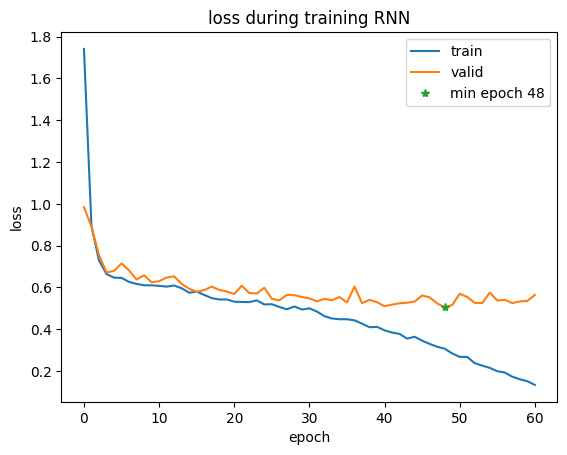

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.543  &0.565  &0.751  &0.410

Epoch:61, [Train] Loss: 0.122
Epoch:61, [Valid] Loss: 0.518
EarlyStopping counter: 13 out of 20
Epoch:62, [Train] Loss: 0.117
Epoch:62, [Valid] Loss: 0.525
EarlyStopping counter: 14 out of 20
Epoch:63, [Train] Loss: 0.105
Epoch:63, [Valid] Loss: 0.531
EarlyStopping counter: 15 out of 20
Epoch:64, [Train] Loss: 0.093
Epoch:64, [Valid] Loss: 0.538
EarlyStopping counter: 16 out of 20
Epoch:65, [Train] Loss: 0.090
Epoch:65, [Valid] Loss: 0.553
EarlyStopping counter: 17 out of 20
Epoch:66, [Train] Loss: 0.084
Epoch:66, [Valid] Loss: 0.535
EarlyStopping counter: 18 out of 20
Epoch:67, [Train] Loss: 0.072
Epoch:67, [Valid] Loss: 0.542
EarlyStopping counter: 19 out of 20
Epoch:68, [Train] Loss: 0.070
Epoch:68, [Valid] Loss: 0.532
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2949905
Train time: 0.734+/-0.011 ms
best epoch: 48, min loss: 0.5050


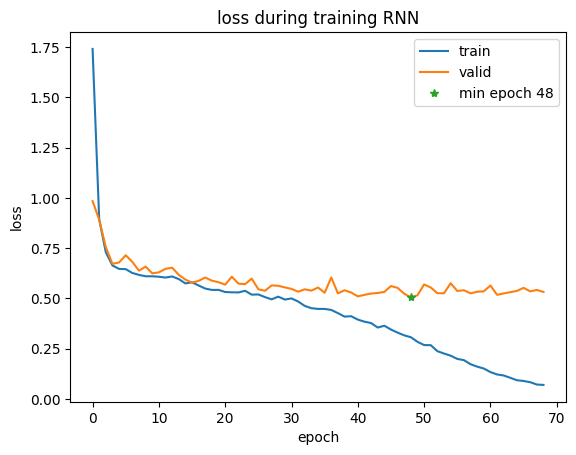

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', ']', 'c', 'i', 'l', 'n', 'o', 'r', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['LD50_Zhu']
dropout : 0.1
IS_R : [True]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/LD50_Zhu_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/LD50_Zhu_char_ST.pt
[Test] Loss: 0.455
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.497  &0.455  &0.674  &0.491


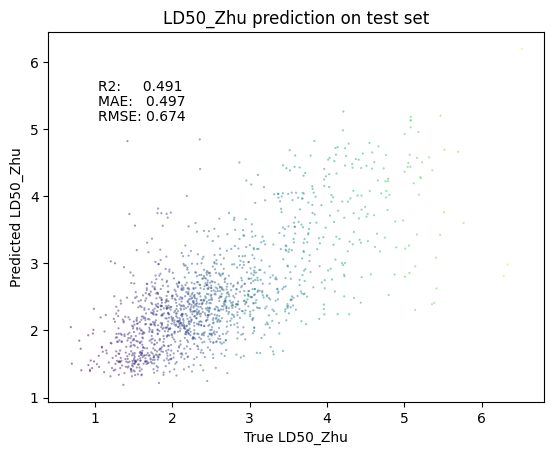

Found local copy...
Loading...
Done!



collect data for:  ['CYP2C19_Veith']
train: 8866 | valid: 1266 | test: 2533 | total: 12665
Alphabet:None



---> loader for ['CYP2C19_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 56
path: RNN/ already exists
Model type:  RNN | Model parameters:  2982465
Epoch:0, [Train] Loss: 0.644
Epoch:0, [Valid] Loss: 0.590
	SAVE MODEL: loss: inf -> 0.590 | runtime: 1.226 ms
Epoch:1, [Train] Loss: 0.583
Epoch:1, [Valid] Loss: 0.550
	SAVE MODEL: loss: 0.590 -> 0.550 | runtime: 1.240 ms
Epoch:2, [Train] Loss: 0.557
Epoch:2, [Valid] Loss: 0.550
EarlyStopping counter: 1 out of 20
Epoch:3, [Train] Loss: 0.548
Epoch:3, [Valid] Loss: 0.535
	SAVE MODEL: loss: 0.550 -> 0.535 | runtime: 1.210 ms
Epoch:4, [Train] Loss: 0.535
Epoch:4, [Valid] Loss: 0.529
	SAVE MODEL: loss: 0.535 -> 0.529 | runtime: 1.200 ms
Epoch:5, [Train] Loss: 0.533
Epo

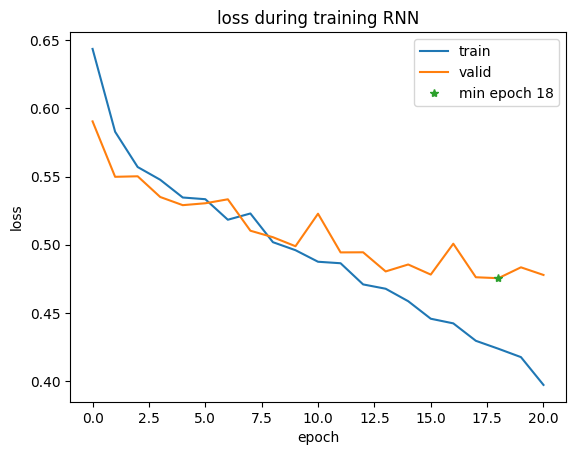

*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.797  &  0.795  &          0.794  &     0.766  &0.825  &0.779 &0.864 &   0.592 &   0.829

Epoch:21, [Train] Loss: 0.391
Epoch:21, [Valid] Loss: 0.469
	SAVE MODEL: loss: 0.475 -> 0.469 | runtime: 1.233 ms
Epoch:22, [Train] Loss: 0.379
Epoch:22, [Valid] Loss: 0.475
EarlyStopping counter: 1 out of 20
Epoch:23, [Train] Loss: 0.357
Epoch:23, [Valid] Loss: 0.508
EarlyStopping counter: 2 out of 20
Epoch:24, [Train] Loss: 0.340
Epoch:24, [Valid] Loss: 0.518
EarlyStopping counter: 3 out of 20
Epoch:25, [Train] Loss: 0.334
Epoch:25, [Valid] Loss: 0.507
EarlyStopping counter: 4 out of 20
Epoch:26, [Train] Loss: 0.300
Epoch:26, [Valid] Loss: 0.551
EarlyStopping counter: 5 out of 20
Epoch:27, [Train] Loss: 0.280
Epoch:27, [Valid] Loss: 0.570
EarlyStopping counter: 6 out of 20
Epoch:28, [Train] Loss: 0.259
Epoch:28, [Valid] Loss: 0.575
EarlyStopping counter: 7 out 

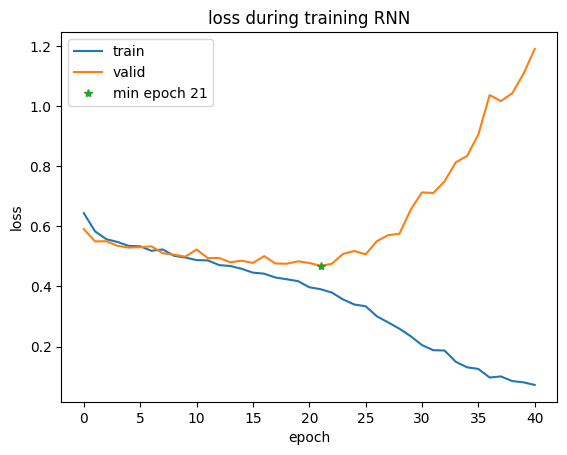

*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.772  &  0.776  &          0.721  &     0.836  &0.715  &0.774 &0.836 &   0.552 &   0.797

Epoch:41, [Train] Loss: 0.067
Epoch:41, [Valid] Loss: 1.231
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2982465
Train time: 1.222+/-0.018 ms
best epoch: 21, min loss: 0.4687


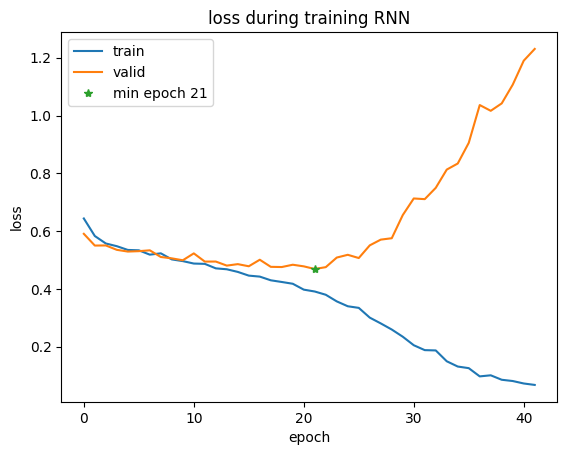

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'W', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'r', 's', 't', 'u']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['CYP2C19_Veith']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/CYP2C19_Veith_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/CYP2C19_Veith_char_ST.pt


Found local copy...
Loading...
Done!


[Test] Loss: 0.489
*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.780  &  0.779  &          0.761  &     0.760  &0.798  &0.761 &0.851 &   0.558 &   0.797

collect data for:  ['CYP2D6_Veith']
train: 9191 | valid: 1313 | test: 2626 | total: 13130
Alphabet:None



---> loader for ['CYP2D6_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 56
path: RNN/ already exists
Model type:  RNN | Model parameters:  2982465
Epoch:0, [Train] Loss: 0.500
Epoch:0, [Valid] Loss: 0.475
	SAVE MODEL: loss: inf -> 0.475 | runtime: 1.191 ms
Epoch:1, [Train] Loss: 0.444
Epoch:1, [Valid] Loss: 0.438
	SAVE MODEL: loss: 0.475 -> 0.438 | runtime: 1.213 ms
Epoch:2, [Train] Loss: 0.415
Epoch:2, [Valid] Loss: 0.430
	SAVE MODEL: loss: 0.438 -> 0.430 | runtime: 1.1

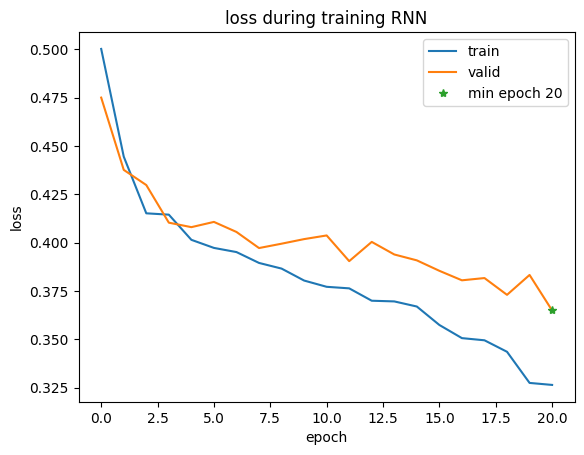

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.839  &  0.707  &          0.617  &     0.488  &0.925  &0.545 &0.843 &   0.453 &   0.622

Epoch:21, [Train] Loss: 0.316
Epoch:21, [Valid] Loss: 0.373
EarlyStopping counter: 1 out of 20
Epoch:22, [Train] Loss: 0.307
Epoch:22, [Valid] Loss: 0.375
EarlyStopping counter: 2 out of 20
Epoch:23, [Train] Loss: 0.298
Epoch:23, [Valid] Loss: 0.387
EarlyStopping counter: 3 out of 20
Epoch:24, [Train] Loss: 0.282
Epoch:24, [Valid] Loss: 0.378
EarlyStopping counter: 4 out of 20
Epoch:25, [Train] Loss: 0.283
Epoch:25, [Valid] Loss: 0.382
EarlyStopping counter: 5 out of 20
Epoch:26, [Train] Loss: 0.259
Epoch:26, [Valid] Loss: 0.400
EarlyStopping counter: 6 out of 20
Epoch:27, [Train] Loss: 0.240
Epoch:27, [Valid] Loss: 0.435
EarlyStopping counter: 7 out of 20
Epoch:28, [Train] Loss: 0.228
Epoch:28, [Valid] Loss: 0.431
EarlyStopping counter: 8 out of 20
Epoch:29, [Tra

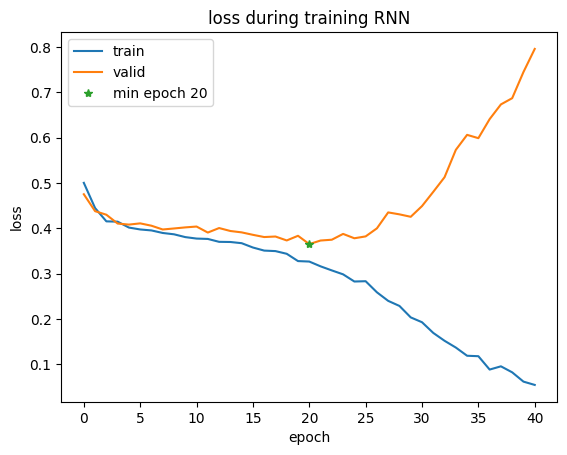

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.832  &  0.739  &          0.576  &     0.585  &0.894  &0.580 &0.831 &   0.476 &   0.609

early stop
Model parameters:  2982465
Train time: 1.210+/-0.016 ms
best epoch: 20, min loss: 0.3649


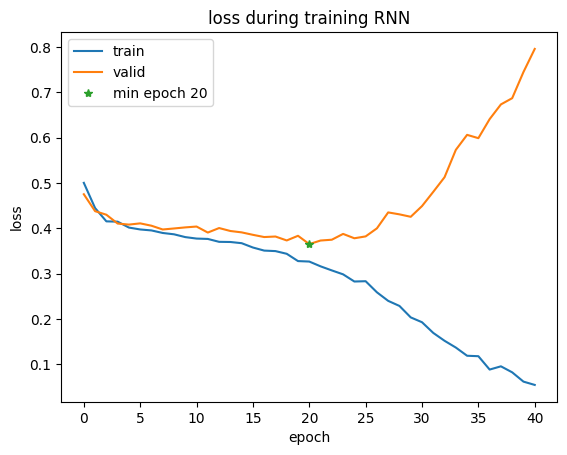

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'W', 'Z', '[', '\\', ']', 'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'r', 's', 't', 'u']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['CYP2D6_Veith']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/CYP2D6_Veith_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/CYP2D6_Veith_char_ST.pt


Found local copy...
Loading...
Done!


[Test] Loss: 0.381
*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.840  &  0.694  &          0.589  &     0.461  &0.927  &0.517 &0.814 &   0.428 &   0.571

collect data for:  ['CYP3A4_Veith']
train: 8629 | valid: 1233 | test: 2466 | total: 12328
Alphabet:None



---> loader for ['CYP3A4_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 56
path: RNN/ already exists
Model type:  RNN | Model parameters:  2982465
Epoch:0, [Train] Loss: 0.653


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch:0, [Valid] Loss: 0.602
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-1e17c566a1b8>", line 22, in <cell line: 4>
    models.train(train_l, valid_l, test_l)
  File "/content/drive/MyDrive/ADMET/scripts/train.py", line 215, in train
  File "/usr/local/lib/python3.10/dist-packages/dgllife/utils/early_stop.py", line 158, in step
    self.save_checkpoint(model)
  File "/usr/local/lib/python3.10/dist-packages/dgllife/utils/early_stop.py", line 179, in save_checkpoint
    torch.save({'model_state_dict': model.state_dict(),
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 618, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 492, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/us

In [ ]:
# Models, Configs, Test_loaders = [], [], []
# model_type = 'RNN'

# for name in list(names_dict.keys()):
#     # if name != 'LD50_Zhu': pass
#     # else: print(name)
#     names = [name]
#     trains, valids, tests = collect_data_10_27(names)
#     print(f'train: {len(trains)} | valid: {len(valids)} | test: {len(tests)} | '
#           f'total: {len(trains) + len(valids) + len(tests)}')
#     config = get_config(model_type, names)
#     if config['vocab'] == None: print('Alphabet:None\n\n\n')
#     train_l, valid_l, test_l, vocab = get_multi_loader(trains, valids, tests, config)
#     if vocab != None and config['vocab'] == None:
#         config['vocab'] = vocab
#         print('RNN, no vocab provided, update vocab using dataset')
#         print('updated vocab length:', len(vocab))
#     make_path('RNN/', False)
#     config['model_path'] = f'RNN/{name}_char_ST.pt'
#     Configs.append(config); Test_loaders.append(test_l)
#     models = PRED(**config)
#     models.train(train_l, valid_l, test_l)
#     Models.append(models)

In [ ]:
# print('---> Then single task results: ')
# for i, name in enumerate(names):
#     print('#'*80)
#     print(name)
#     print('#'*80)
#     models = Models[i]
#     test_loader = Test_loaders[i]
#     config = Configs[i]
#     models.eval(test_loader, config['model_path'], True)

Found local copy...
Loading...
Done!


CYP3A4_Veith
collect data for:  ['CYP3A4_Veith']
train: 8629 | valid: 1233 | test: 2466 | total: 12328
Alphabet:None



---> loader for ['CYP3A4_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 60
Model type:  RNN | Model parameters:  2989073
Epoch:0, [Train] Loss: 0.657
Epoch:0, [Valid] Loss: 0.651
	 SAVE MODEL: loss: inf -> 0.651 | runtime: 1.157 ms
Epoch:1, [Train] Loss: 0.573
Epoch:1, [Valid] Loss: 0.576
	 SAVE MODEL: loss: 0.651 -> 0.576 | runtime: 1.220 ms
Epoch:2, [Train] Loss: 0.544
Epoch:2, [Valid] Loss: 0.582
EarlyStopping counter: 1 out of 20
Epoch:3, [Train] Loss: 0.537
Epoch:3, [Valid] Loss: 0.566
	 SAVE MODEL: loss: 0.576 -> 0.566 | runtime: 1.180 ms
Epoch:4, [Train] Loss: 0.530
Epoch:4, [Valid] Loss: 0.551
	 SAVE MODEL: loss: 0.566 -> 0.551 | runtime: 1.153 ms
Epoch:5, [Train] Loss: 0.528
Epoch:5, [Valid

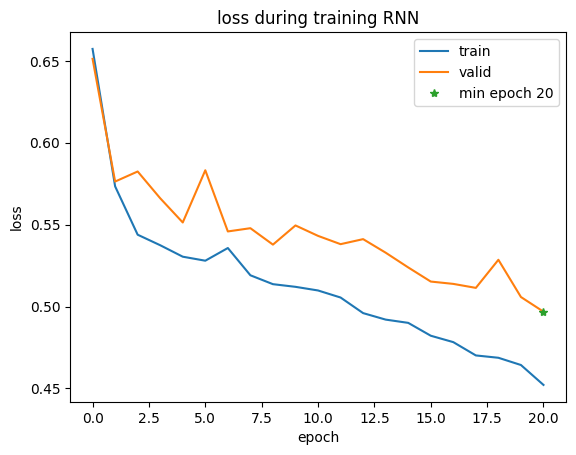

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.733  &  0.713  &          0.721  &     0.591  &0.835  &0.650 &0.828 &   0.443 &   0.771

Epoch:21, [Train] Loss: 0.458
Epoch:21, [Valid] Loss: 0.499
EarlyStopping counter: 1 out of 20
Epoch:22, [Train] Loss: 0.443
Epoch:22, [Valid] Loss: 0.486
	 SAVE MODEL: loss: 0.497 -> 0.486 | runtime: 1.167 ms
Epoch:23, [Train] Loss: 0.431
Epoch:23, [Valid] Loss: 0.493
EarlyStopping counter: 1 out of 20
Epoch:24, [Train] Loss: 0.425
Epoch:24, [Valid] Loss: 0.492
EarlyStopping counter: 2 out of 20
Epoch:25, [Train] Loss: 0.413
Epoch:25, [Valid] Loss: 0.493
EarlyStopping counter: 3 out of 20
Epoch:26, [Train] Loss: 0.415
Epoch:26, [Valid] Loss: 0.492
EarlyStopping counter: 4 out of 20
Epoch:27, [Train] Loss: 0.390
Epoch:27, [Valid] Loss: 0.489
EarlyStopping counter: 5 out of 20
Epoch:28, [Train] Loss: 0.381
Epoch:28, [Valid] Loss: 0.477
	 SAVE MODEL: loss: 0.486 -> 

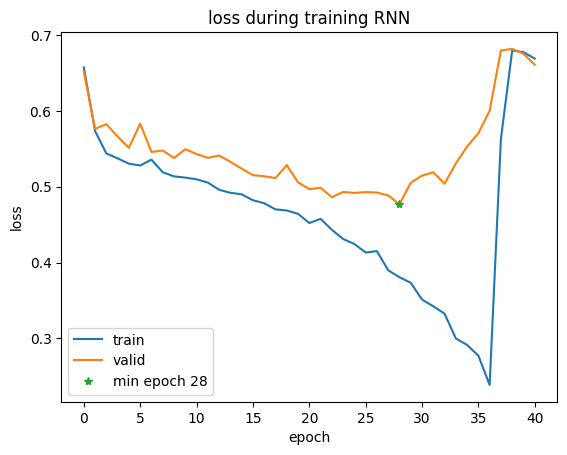

*************** CYP3A4_Veith ***************
equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
TP, FP, TN, FN 0 0 717 516
temp=0
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.582  &  0.500  &            nan  &     0.000  &1.000  &  nan &0.659 &  N/A &   0.583

Epoch:41, [Train] Loss: 0.632
Epoch:41, [Valid] Loss: 0.692
EarlyStopping counter: 13 out of 20
Epoch:42, [Train] Loss: 0.596
Epoch:42, [Valid] Loss: 0.559
EarlyStopping counter: 14 out of 20
Epoch:43, [Train] Loss: 0.544
Epoch:43, [Valid] Loss: 0.576
EarlyStopping counter: 15 out of 20
Epoch:44, [Train] Loss: 0.518
Epoch:44, [Valid] Loss: 0.545
EarlyStopping counter: 16 out of 20
Epoch:45, [Train] Loss: 0.510
Epoch:45, [Valid] Loss: 0.522
EarlyStopping counter: 17 out of 20
Epoch:46, [Train] Loss: 0.491
Epoch:46, [Valid] Loss: 0.521
EarlyStopping counter: 18 out of 20
Epoch:47, [Train] Loss: 0.475
Epoch:47, [Valid] Loss: 0.514
EarlyStopping counter: 19 out of 20
Epoch:48, [Trai

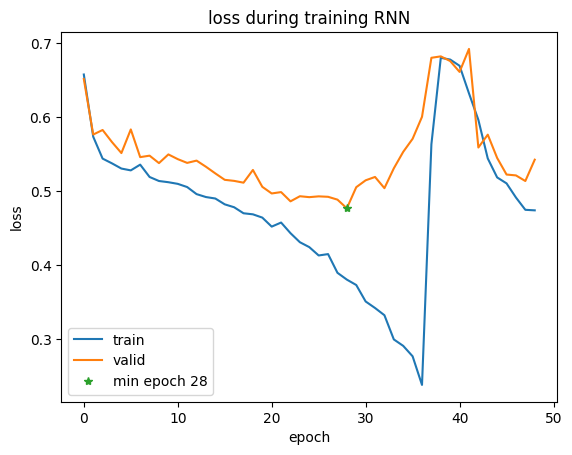

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '%10', '%11', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'As', 'B', 'Br', 'C', 'Ca', 'Cl', 'Cr', 'Cu', 'F', 'Fe', 'H', 'Hg', 'I', 'K', 'Li', 'M', 'N', 'Na', 'Ni', 'O', 'P', 'Pt', 'Ru', 'S', 'Sb', 'Se', 'Si', 'W', 'Z', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim :

Found local copy...
Loading...
Done!


 1
prop_names : ['CYP3A4_Veith']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/CYP3A4_Veith_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/CYP3A4_Veith_char_ST.pt
CYP1A2_Veith
collect data for:  ['CYP1A2_Veith']
train: 8805 | valid: 1258 | test: 2516 | total: 12579
Alphabet:None



---> loader for ['CYP1A2_Veith']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 60
Model type:  RNN | Model parameters:  2989073
Epoch:0, [Train] Loss: 0.563
Epoch:0, [Valid] Loss: 0.505
	 SAVE MODEL: loss: inf -> 0.505 | runtime: 1.193 ms
Epoch:1, [Train] Loss: 0.507
Epoch:1, [Valid] Loss: 0.492
	 SAVE MODEL: loss: 0.505 -> 0.492 | runtime: 1.189 ms
Epoch:2, [Train] Loss: 0.490
Ep

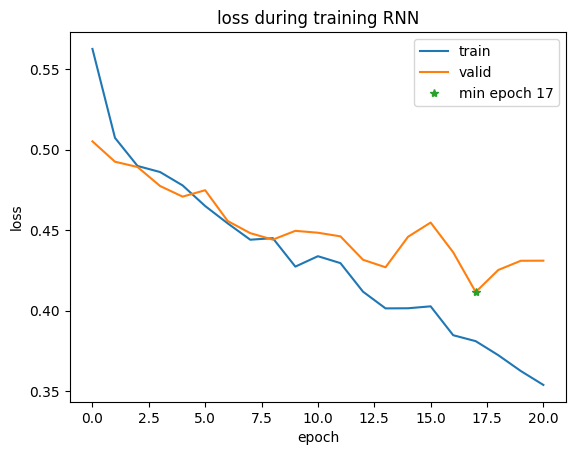

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.813  &  0.807  &          0.846  &     0.728  &0.886  &0.783 &0.893 &   0.626 &   0.876

Epoch:21, [Train] Loss: 0.346
Epoch:21, [Valid] Loss: 0.420
EarlyStopping counter: 4 out of 20
Epoch:22, [Train] Loss: 0.337
Epoch:22, [Valid] Loss: 0.437
EarlyStopping counter: 5 out of 20
Epoch:23, [Train] Loss: 0.331
Epoch:23, [Valid] Loss: 0.445
EarlyStopping counter: 6 out of 20
Epoch:24, [Train] Loss: 0.319
Epoch:24, [Valid] Loss: 0.404
	 SAVE MODEL: loss: 0.412 -> 0.404 | runtime: 1.210 ms
Epoch:25, [Train] Loss: 0.308
Epoch:25, [Valid] Loss: 0.438
EarlyStopping counter: 1 out of 20
Epoch:26, [Train] Loss: 0.296
Epoch:26, [Valid] Loss: 0.436
EarlyStopping counter: 2 out of 20
Epoch:27, [Train] Loss: 0.273
Epoch:27, [Valid] Loss: 0.461
EarlyStopping counter: 3 out of 20
Epoch:28, [Train] Loss: 0.259
Epoch:28, [Valid] Loss: 0.451
EarlyStopping counter: 4 out 

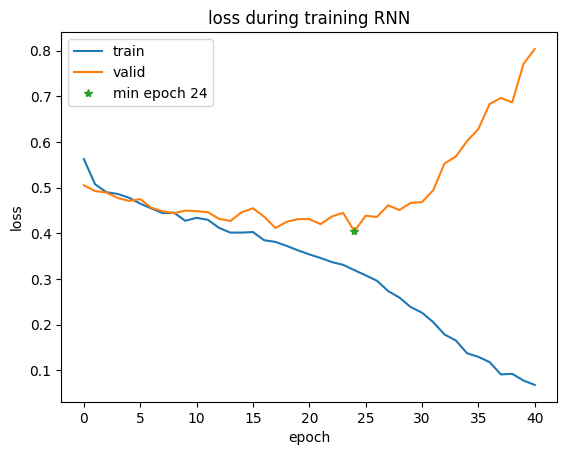

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.824  &  0.820  &          0.829  &     0.778  &0.863  &0.803 &0.882 &   0.645 &   0.865

Epoch:41, [Train] Loss: 0.050
Epoch:41, [Valid] Loss: 0.829
EarlyStopping counter: 17 out of 20
Epoch:42, [Train] Loss: 0.087
Epoch:42, [Valid] Loss: 0.839
EarlyStopping counter: 18 out of 20
Epoch:43, [Train] Loss: 0.072
Epoch:43, [Valid] Loss: 0.828
EarlyStopping counter: 19 out of 20
Epoch:44, [Train] Loss: 0.035
Epoch:44, [Valid] Loss: 0.911
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2989073
Train time: 1.191+/-0.017 ms
best epoch: 24, min loss: 0.4045


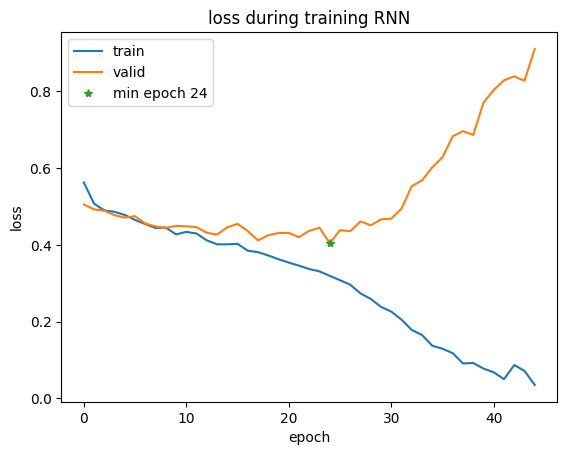

Found local copy...
Loading...
Done!


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '%10', '%11', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'As', 'B', 'Br', 'C', 'Ca', 'Cl', 'Cr', 'Cu', 'F', 'Fe', 'H', 'Hg', 'I', 'K', 'Li', 'M', 'N', 'Na', 'Ni', 'O', 'P', 'Pt', 'S', 'Sb', 'Se', 'Si', 'W', 'Z', '[', '\\', ']', 'c', 'e', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['CYP1A2_Veith']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/CYP1A2_Veith_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/CYP1A2_Veith_char_ST.pt
CYP2C9_Veith
collect data for:  ['CYP2C9_Veit

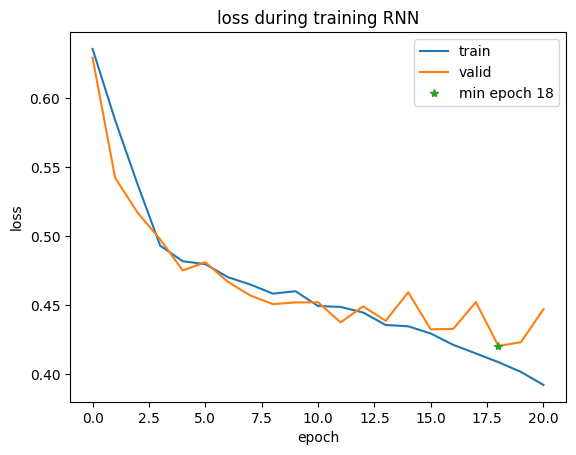

*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.777  &  0.781  &          0.639  &     0.797  &0.766  &0.709 &0.867 &   0.540 &   0.772

Epoch:21, [Train] Loss: 0.389
Epoch:21, [Valid] Loss: 0.418
	 SAVE MODEL: loss: 0.420 -> 0.418 | runtime: 1.145 ms
Epoch:22, [Train] Loss: 0.375
Epoch:22, [Valid] Loss: 0.436
EarlyStopping counter: 1 out of 20
Epoch:23, [Train] Loss: 0.374
Epoch:23, [Valid] Loss: 0.456
EarlyStopping counter: 2 out of 20
Epoch:24, [Train] Loss: 0.349
Epoch:24, [Valid] Loss: 0.433
EarlyStopping counter: 3 out of 20
Epoch:25, [Train] Loss: 0.337
Epoch:25, [Valid] Loss: 0.445
EarlyStopping counter: 4 out of 20
Epoch:26, [Train] Loss: 0.323
Epoch:26, [Valid] Loss: 0.447
EarlyStopping counter: 5 out of 20
Epoch:27, [Train] Loss: 0.305
Epoch:27, [Valid] Loss: 0.478
EarlyStopping counter: 6 out of 20
Epoch:28, [Train] Loss: 0.287
Epoch:28, [Valid] Loss: 0.476
EarlyStopping counter: 7 out 

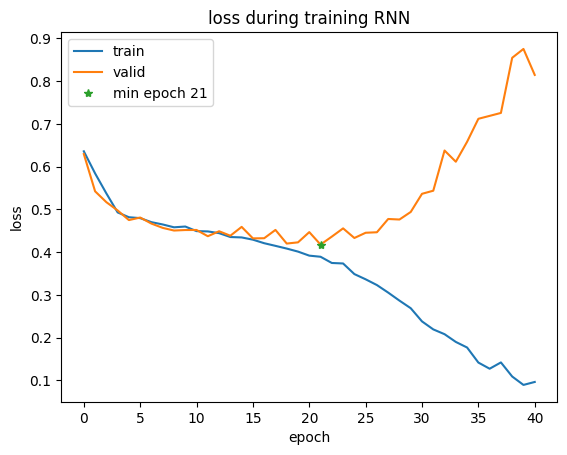

*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.800  &  0.775  &          0.712  &     0.695  &0.854  &0.703 &0.840 &   0.552 &   0.744

Epoch:41, [Train] Loss: 0.108
Epoch:41, [Valid] Loss: 0.864
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2987418
Train time: 1.164+/-0.014 ms
best epoch: 21, min loss: 0.4178


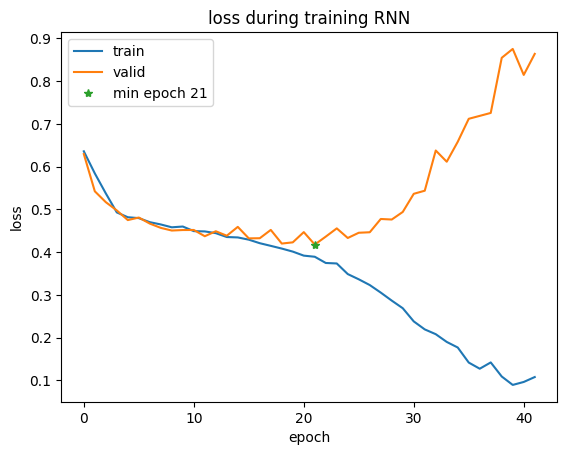

Found local copy...
Loading...


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '%10', '%11', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'As', 'B', 'Br', 'C', 'Ca', 'Cl', 'Cr', 'Cu', 'F', 'Fe', 'H', 'Hg', 'I', 'K', 'Li', 'M', 'N', 'Na', 'Ni', 'O', 'P', 'Pt', 'S', 'Sb', 'Se', 'Si', 'W', 'Z', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['CYP2C9_Veith']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/CYP2C9_Veith_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/CYP2C9_Veith_char_ST.pt
BBB_Martins
collect data for:  ['BBB_Martins']


Done!


train: 1421 | valid: 203 | test: 406 | total: 2030
Alphabet:None



---> loader for ['BBB_Martins']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 41
Model type:  RNN | Model parameters:  2957970
Epoch:0, [Train] Loss: 0.590
Epoch:0, [Valid] Loss: 0.565
	 SAVE MODEL: loss: inf -> 0.565 | runtime: 1.526 ms
Epoch:1, [Train] Loss: 0.543
Epoch:1, [Valid] Loss: 0.575
EarlyStopping counter: 1 out of 20
Epoch:2, [Train] Loss: 0.537
Epoch:2, [Valid] Loss: 0.557
	 SAVE MODEL: loss: 0.565 -> 0.557 | runtime: 1.542 ms
Epoch:3, [Train] Loss: 0.527
Epoch:3, [Valid] Loss: 0.532
	 SAVE MODEL: loss: 0.557 -> 0.532 | runtime: 1.467 ms
Epoch:4, [Train] Loss: 0.492
Epoch:4, [Valid] Loss: 0.478
	 SAVE MODEL: loss: 0.532 -> 0.478 | runtime: 1.506 ms
Epoch:5, [Train] Loss: 0.457
Epoch:5, [Valid] Loss: 0.447
	 SAVE MODEL: loss: 0.478 -> 0.447 | ru

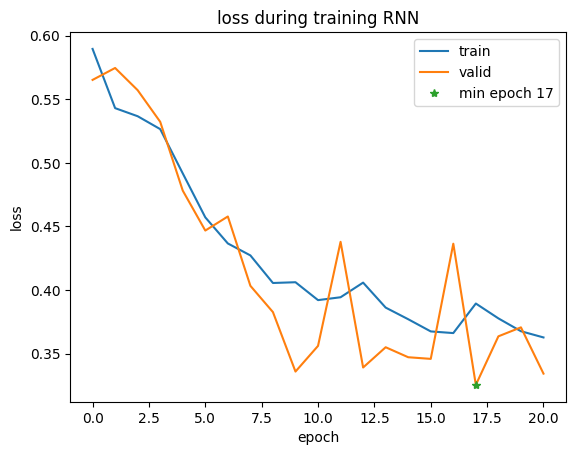

*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.872  &  0.784  &          0.880  &     0.961  &0.608  &0.918 &0.894 &   0.639 &   0.956

Epoch:21, [Train] Loss: 0.359
Epoch:21, [Valid] Loss: 0.331
EarlyStopping counter: 4 out of 20
Epoch:22, [Train] Loss: 0.355
Epoch:22, [Valid] Loss: 0.324
	 SAVE MODEL: loss: 0.325 -> 0.324 | runtime: 1.447 ms
Epoch:23, [Train] Loss: 0.347
Epoch:23, [Valid] Loss: 0.345
EarlyStopping counter: 1 out of 20
Epoch:24, [Train] Loss: 0.347
Epoch:24, [Valid] Loss: 0.350
EarlyStopping counter: 2 out of 20
Epoch:25, [Train] Loss: 0.340
Epoch:25, [Valid] Loss: 0.322
	 SAVE MODEL: loss: 0.324 -> 0.322 | runtime: 1.515 ms
Epoch:26, [Train] Loss: 0.329
Epoch:26, [Valid] Loss: 0.349
EarlyStopping counter: 1 out of 20
Epoch:27, [Train] Loss: 0.351
Epoch:27, [Valid] Loss: 0.371
EarlyStopping counter: 2 out of 20
Epoch:28, [Train] Loss: 0.348
Epoch:28, [Valid] Loss: 0.323
EarlyStopp

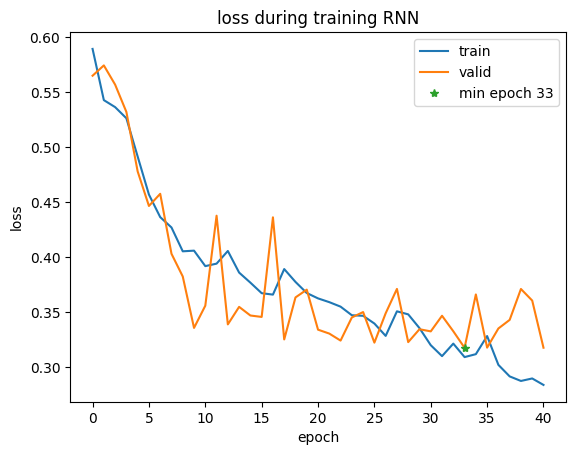

*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.892  &  0.823  &          0.901  &     0.961  &0.686  &0.930 &0.885 &   0.699 &   0.946

Epoch:41, [Train] Loss: 0.264
Epoch:41, [Valid] Loss: 0.316
	 SAVE MODEL: loss: 0.318 -> 0.316 | runtime: 1.511 ms
Epoch:42, [Train] Loss: 0.254
Epoch:42, [Valid] Loss: 0.346
EarlyStopping counter: 1 out of 20
Epoch:43, [Train] Loss: 0.281
Epoch:43, [Valid] Loss: 0.323
EarlyStopping counter: 2 out of 20
Epoch:44, [Train] Loss: 0.272
Epoch:44, [Valid] Loss: 0.327
EarlyStopping counter: 3 out of 20
Epoch:45, [Train] Loss: 0.251
Epoch:45, [Valid] Loss: 0.322
EarlyStopping counter: 4 out of 20
Epoch:46, [Train] Loss: 0.233
Epoch:46, [Valid] Loss: 0.346
EarlyStopping counter: 5 out of 20
Epoch:47, [Train] Loss: 0.215
Epoch:47, [Valid] Loss: 0.309
	 SAVE MODEL: loss: 0.316 -> 0.309 | runtime: 1.544 ms
Epoch:48, [Train] Loss: 0.228
Epoch:48, [Valid] Loss: 0.337
EarlyStopp

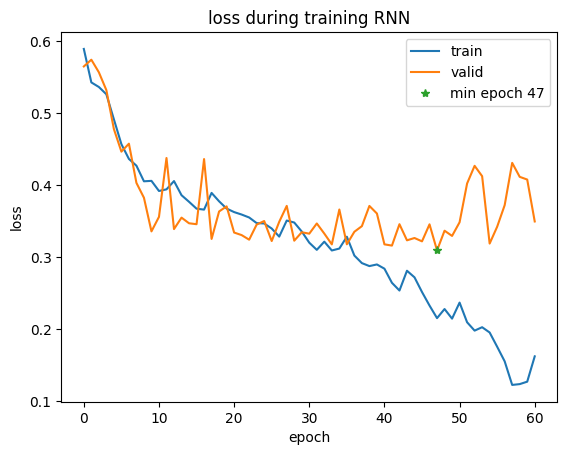

*************** BBB_Martins ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.862  &  0.823  &          0.913  &     0.901  &0.745  &0.907 &0.921 &   0.638 &   0.969

Epoch:61, [Train] Loss: 0.107
Epoch:61, [Valid] Loss: 0.449
EarlyStopping counter: 14 out of 20
Epoch:62, [Train] Loss: 0.112
Epoch:62, [Valid] Loss: 0.415
EarlyStopping counter: 15 out of 20
Epoch:63, [Train] Loss: 0.123
Epoch:63, [Valid] Loss: 0.473
EarlyStopping counter: 16 out of 20
Epoch:64, [Train] Loss: 0.113
Epoch:64, [Valid] Loss: 0.353
EarlyStopping counter: 17 out of 20
Epoch:65, [Train] Loss: 0.116
Epoch:65, [Valid] Loss: 0.418
EarlyStopping counter: 18 out of 20
Epoch:66, [Train] Loss: 0.098
Epoch:66, [Valid] Loss: 0.471
EarlyStopping counter: 19 out of 20
Epoch:67, [Train] Loss: 0.075
Epoch:67, [Valid] Loss: 0.408
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2957970
Train time: 1.507+/-0.036 ms
best epoch: 47, min loss: 0.3093


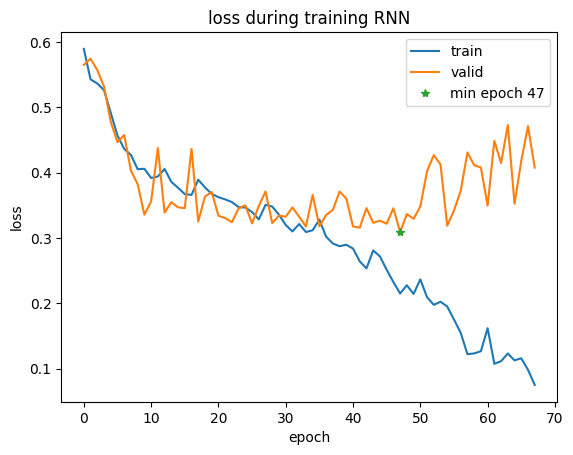

Found local copy...
Loading...


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', '@', 'B', 'Br', 'C', 'Ca', 'Cl', 'F', 'H', 'I', 'N', 'Na', 'O', 'P', 'S', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['BBB_Martins']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/BBB_Martins_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/BBB_Martins_char_ST.pt
Bioavailability_Ma
collect data for:  ['Bioavailability_Ma']


Done!


train: 448 | valid: 64 | test: 128 | total: 640
Alphabet:None



---> loader for ['Bioavailability_Ma']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 40
Model type:  RNN | Model parameters:  2956353
Epoch:0, [Train] Loss: 0.666
Epoch:0, [Valid] Loss: 0.560
	 SAVE MODEL: loss: inf -> 0.560 | runtime: 1.314 ms
Epoch:1, [Train] Loss: 0.539
Epoch:1, [Valid] Loss: 0.551
	 SAVE MODEL: loss: 0.560 -> 0.551 | runtime: 1.313 ms
Epoch:2, [Train] Loss: 0.564
Epoch:2, [Valid] Loss: 0.506
	 SAVE MODEL: loss: 0.551 -> 0.506 | runtime: 1.311 ms
Epoch:3, [Train] Loss: 0.531
Epoch:3, [Valid] Loss: 0.521
EarlyStopping counter: 1 out of 20
Epoch:4, [Train] Loss: 0.530
Epoch:4, [Valid] Loss: 0.504
	 SAVE MODEL: loss: 0.506 -> 0.504 | runtime: 1.330 ms
Epoch:5, [Train] Loss: 0.524
Epoch:5, [Valid] Loss: 0.501
	 SAVE MODEL: loss: 0.504 -> 0.501 

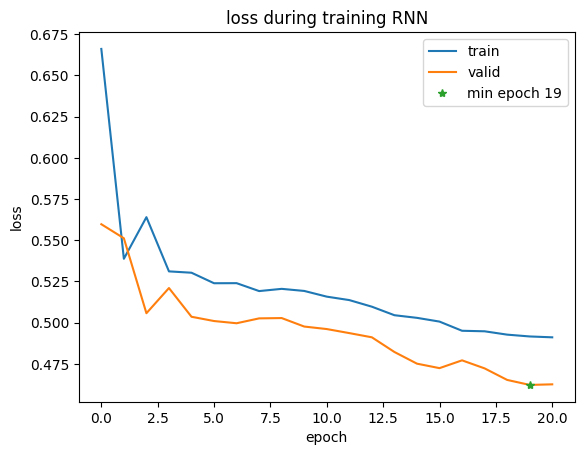

*************** Bioavailability_Ma ***************
equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
TP, FP, TN, FN 51 13 0 0
temp=0
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.797  &  0.500  &          0.797  &     1.000  &0.000  &0.887 &0.641 &  N/A &   0.839

Epoch:21, [Train] Loss: 0.485
Epoch:21, [Valid] Loss: 0.463
EarlyStopping counter: 2 out of 20
Epoch:22, [Train] Loss: 0.482
Epoch:22, [Valid] Loss: 0.462
EarlyStopping counter: 3 out of 20
Epoch:23, [Train] Loss: 0.480
Epoch:23, [Valid] Loss: 0.460
	 SAVE MODEL: loss: 0.462 -> 0.460 | runtime: 1.356 ms
Epoch:24, [Train] Loss: 0.474
Epoch:24, [Valid] Loss: 0.467
EarlyStopping counter: 1 out of 20
Epoch:25, [Train] Loss: 0.490
Epoch:25, [Valid] Loss: 0.496
EarlyStopping counter: 2 out of 20
Epoch:26, [Train] Loss: 0.492
Epoch:26, [Valid] Loss: 0.491
EarlyStopping counter: 3 out of 20
Epoch:27, [Train] Loss: 0.490
Epoch:27, [Valid] Loss: 0.479
EarlyStopping counter: 4 out of 2

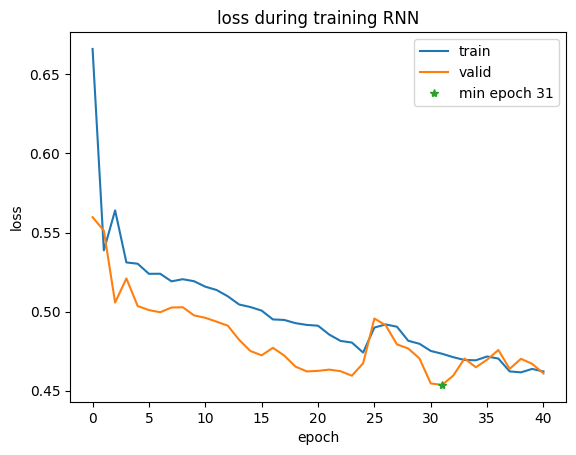

*************** Bioavailability_Ma ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.828  &  0.606  &          0.833  &     0.980  &0.231  &0.901 &0.650 &   0.351 &   0.834

Epoch:41, [Train] Loss: 0.459
Epoch:41, [Valid] Loss: 0.454
EarlyStopping counter: 10 out of 20
Epoch:42, [Train] Loss: 0.455
Epoch:42, [Valid] Loss: 0.454
EarlyStopping counter: 11 out of 20
Epoch:43, [Train] Loss: 0.456
Epoch:43, [Valid] Loss: 0.455
EarlyStopping counter: 12 out of 20
Epoch:44, [Train] Loss: 0.459
Epoch:44, [Valid] Loss: 0.464
EarlyStopping counter: 13 out of 20
Epoch:45, [Train] Loss: 0.450
Epoch:45, [Valid] Loss: 0.473
EarlyStopping counter: 14 out of 20
Epoch:46, [Train] Loss: 0.447
Epoch:46, [Valid] Loss: 0.471
EarlyStopping counter: 15 out of 20
Epoch:47, [Train] Loss: 0.441
Epoch:47, [Valid] Loss: 0.470
EarlyStopping counter: 16 out of 20
Epoch:48, [Train] Loss: 0.440
Epoch:48, [Valid] Loss: 0.489
EarlyStopping counter: 17 out of 20


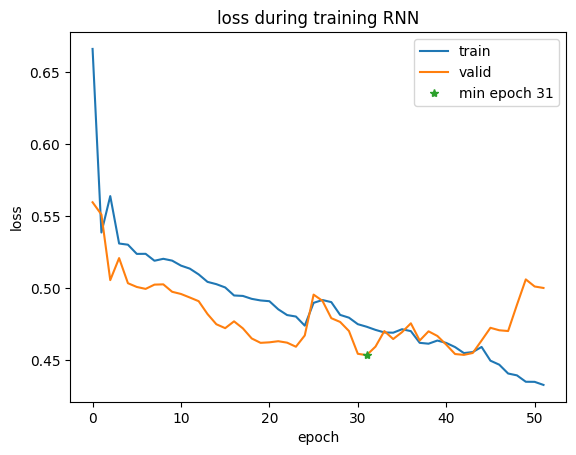

Found local copy...
Loading...


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'Au', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['Bioavailability_Ma']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/Bioavailability_Ma_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/Bioavailability_Ma_char_ST.pt
Pgp_Broccatelli
collect data for:  ['Pgp_Broccatelli']


Done!


train: 852 | valid: 122 | test: 244 | total: 1218
Alphabet:None



---> loader for ['Pgp_Broccatelli']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 36
Model type:  RNN | Model parameters:  2949905
Epoch:0, [Train] Loss: 0.694
Epoch:0, [Valid] Loss: 0.690
	 SAVE MODEL: loss: inf -> 0.690 | runtime: 0.978 ms
Epoch:1, [Train] Loss: 0.689
Epoch:1, [Valid] Loss: 0.687
	 SAVE MODEL: loss: 0.690 -> 0.687 | runtime: 1.002 ms
Epoch:2, [Train] Loss: 0.682
Epoch:2, [Valid] Loss: 0.668
	 SAVE MODEL: loss: 0.687 -> 0.668 | runtime: 1.004 ms
Epoch:3, [Train] Loss: 0.629
Epoch:3, [Valid] Loss: 0.586
	 SAVE MODEL: loss: 0.668 -> 0.586 | runtime: 1.023 ms
Epoch:4, [Train] Loss: 0.551
Epoch:4, [Valid] Loss: 0.507
	 SAVE MODEL: loss: 0.586 -> 0.507 | runtime: 1.023 ms
Epoch:5, [Train] Loss: 0.502
Epoch:5, [Valid] Loss: 0.641
EarlyStopping co

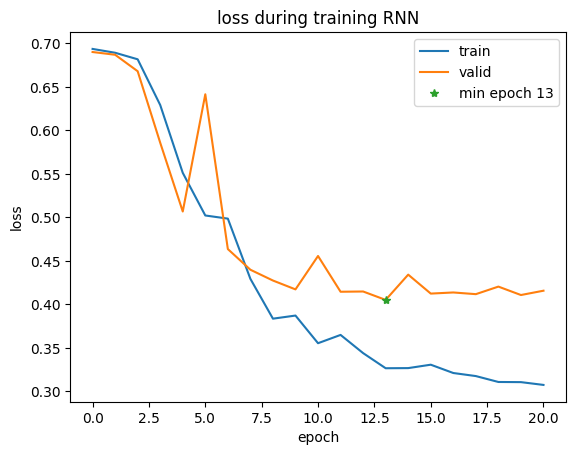

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.820  &  0.823  &          0.867  &     0.788  &0.857  &0.825 &0.897 &   0.643 &   0.916

Epoch:21, [Train] Loss: 0.303
Epoch:21, [Valid] Loss: 0.411
EarlyStopping counter: 8 out of 20
Epoch:22, [Train] Loss: 0.304
Epoch:22, [Valid] Loss: 0.436
EarlyStopping counter: 9 out of 20
Epoch:23, [Train] Loss: 0.310
Epoch:23, [Valid] Loss: 0.445
EarlyStopping counter: 10 out of 20
Epoch:24, [Train] Loss: 0.321
Epoch:24, [Valid] Loss: 0.448
EarlyStopping counter: 11 out of 20
Epoch:25, [Train] Loss: 0.334
Epoch:25, [Valid] Loss: 0.456
EarlyStopping counter: 12 out of 20
Epoch:26, [Train] Loss: 0.336
Epoch:26, [Valid] Loss: 0.407
EarlyStopping counter: 13 out of 20
Epoch:27, [Train] Loss: 0.313
Epoch:27, [Valid] Loss: 0.451
EarlyStopping counter: 14 out of 20
Epoch:28, [Train] Loss: 0.315
Epoch:28, [Valid] Loss: 0.431
EarlyStopping counter: 15 out of 20
Epoch

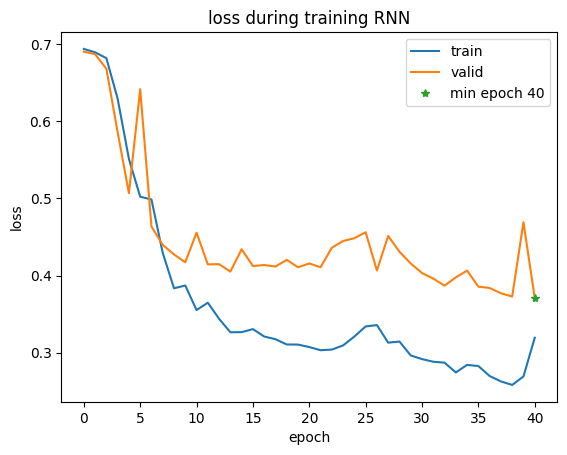

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.836  &  0.839  &          0.883  &     0.803  &0.875  &0.841 &0.915 &   0.676 &   0.927

Epoch:41, [Train] Loss: 0.267
Epoch:41, [Valid] Loss: 0.363
	 SAVE MODEL: loss: 0.371 -> 0.363 | runtime: 0.967 ms
Epoch:42, [Train] Loss: 0.252
Epoch:42, [Valid] Loss: 0.385
EarlyStopping counter: 1 out of 20
Epoch:43, [Train] Loss: 0.257
Epoch:43, [Valid] Loss: 0.445
EarlyStopping counter: 2 out of 20
Epoch:44, [Train] Loss: 0.266
Epoch:44, [Valid] Loss: 0.411
EarlyStopping counter: 3 out of 20
Epoch:45, [Train] Loss: 0.270
Epoch:45, [Valid] Loss: 0.424
EarlyStopping counter: 4 out of 20
Epoch:46, [Train] Loss: 0.297
Epoch:46, [Valid] Loss: 0.411
EarlyStopping counter: 5 out of 20
Epoch:47, [Train] Loss: 0.260
Epoch:47, [Valid] Loss: 0.392
EarlyStopping counter: 6 out of 20
Epoch:48, [Train] Loss: 0.252
Epoch:48, [Valid] Loss: 0.377
EarlyStopping counter: 7 o

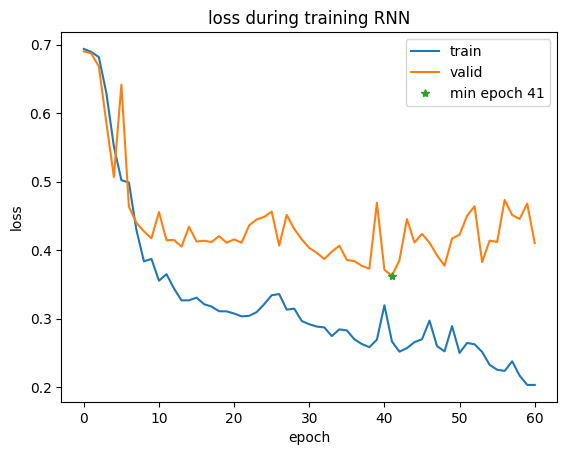

*************** Pgp_Broccatelli ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.844  &  0.849  &          0.912  &     0.788  &0.911  &0.846 &0.909 &   0.698 &   0.921

Epoch:61, [Train] Loss: 0.213
Epoch:61, [Valid] Loss: 0.442
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2949905
Train time: 1.014+/-0.022 ms
best epoch: 41, min loss: 0.3626


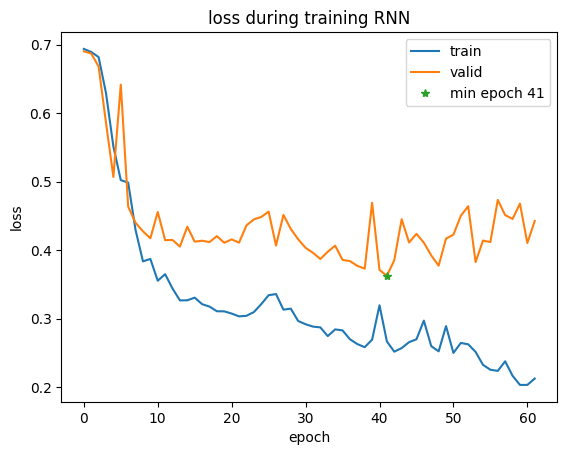

Found local copy...
Loading...


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['Pgp_Broccatelli']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/Pgp_Broccatelli_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/Pgp_Broccatelli_char_ST.pt
HIA_Hou
collect data for:  ['HIA_Hou']


Done!


train: 404 | valid: 58 | test: 116 | total: 578
Alphabet:None



---> loader for ['HIA_Hou']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 38
Model type:  RNN | Model parameters:  2953125
Epoch:0, [Train] Loss: 0.620
Epoch:0, [Valid] Loss: 0.453
	 SAVE MODEL: loss: inf -> 0.453 | runtime: 1.521 ms
Epoch:1, [Train] Loss: 0.421
Epoch:1, [Valid] Loss: 0.385
	 SAVE MODEL: loss: 0.453 -> 0.385 | runtime: 1.510 ms
Epoch:2, [Train] Loss: 0.458
Epoch:2, [Valid] Loss: 0.333
	 SAVE MODEL: loss: 0.385 -> 0.333 | runtime: 1.521 ms
Epoch:3, [Train] Loss: 0.387
Epoch:3, [Valid] Loss: 0.374
EarlyStopping counter: 1 out of 20
Epoch:4, [Train] Loss: 0.409
Epoch:4, [Valid] Loss: 0.353
EarlyStopping counter: 2 out of 20
Epoch:5, [Train] Loss: 0.389
Epoch:5, [Valid] Loss: 0.332
	 SAVE MODEL: loss: 0.333 -> 0.332 | runtime: 1.446 ms
Epoch:6, [T

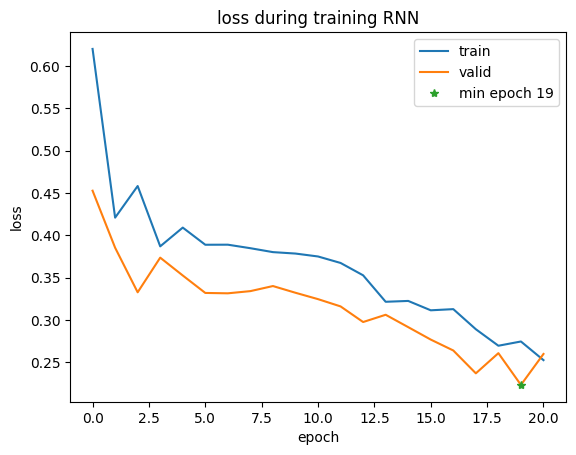

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.914  &  0.804  &          0.961  &     0.942  &0.667  &0.951 &0.830 &   0.569 &   0.971

Epoch:21, [Train] Loss: 0.254
Epoch:21, [Valid] Loss: 0.221
	 SAVE MODEL: loss: 0.224 -> 0.221 | runtime: 1.559 ms
Epoch:22, [Train] Loss: 0.250
Epoch:22, [Valid] Loss: 0.238
EarlyStopping counter: 1 out of 20
Epoch:23, [Train] Loss: 0.247
Epoch:23, [Valid] Loss: 0.218
	 SAVE MODEL: loss: 0.221 -> 0.218 | runtime: 1.492 ms
Epoch:24, [Train] Loss: 0.240
Epoch:24, [Valid] Loss: 0.209
	 SAVE MODEL: loss: 0.218 -> 0.209 | runtime: 1.406 ms
Epoch:25, [Train] Loss: 0.203
Epoch:25, [Valid] Loss: 0.221
EarlyStopping counter: 1 out of 20
Epoch:26, [Train] Loss: 0.201
Epoch:26, [Valid] Loss: 0.224
EarlyStopping counter: 2 out of 20
Epoch:27, [Train] Loss: 0.199
Epoch:27, [Valid] Loss: 0.254
EarlyStopping counter: 3 out of 20
Epoch:28, [Train] Loss: 0.189
Epoch:28, [Valid] Loss: 

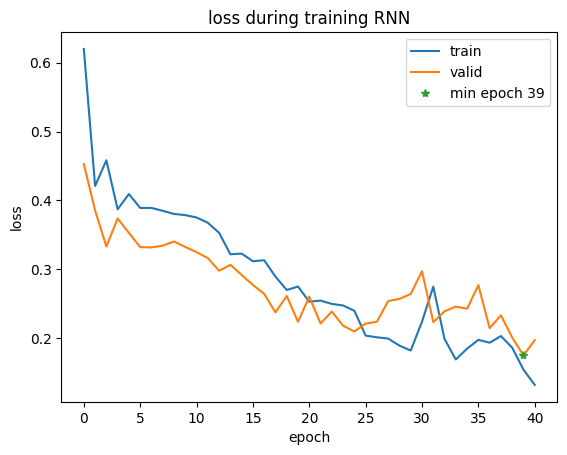

*************** HIA_Hou ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.931  &  0.814  &          0.962  &     0.962  &0.667  &0.962 &0.933 &   0.628 &   0.992

Epoch:41, [Train] Loss: 0.132
Epoch:41, [Valid] Loss: 0.219
EarlyStopping counter: 2 out of 20
Epoch:42, [Train] Loss: 0.146
Epoch:42, [Valid] Loss: 0.317
EarlyStopping counter: 3 out of 20
Epoch:43, [Train] Loss: 0.142
Epoch:43, [Valid] Loss: 0.197
EarlyStopping counter: 4 out of 20
Epoch:44, [Train] Loss: 0.152
Epoch:44, [Valid] Loss: 0.187
EarlyStopping counter: 5 out of 20
Epoch:45, [Train] Loss: 0.125
Epoch:45, [Valid] Loss: 0.185
EarlyStopping counter: 6 out of 20
Epoch:46, [Train] Loss: 0.111
Epoch:46, [Valid] Loss: 0.194
EarlyStopping counter: 7 out of 20
Epoch:47, [Train] Loss: 0.108
Epoch:47, [Valid] Loss: 0.207
EarlyStopping counter: 8 out of 20
Epoch:48, [Train] Loss: 0.104
Epoch:48, [Valid] Loss: 0.219
EarlyStopping counter: 9 out of 20
Epoch:49, [Train] L

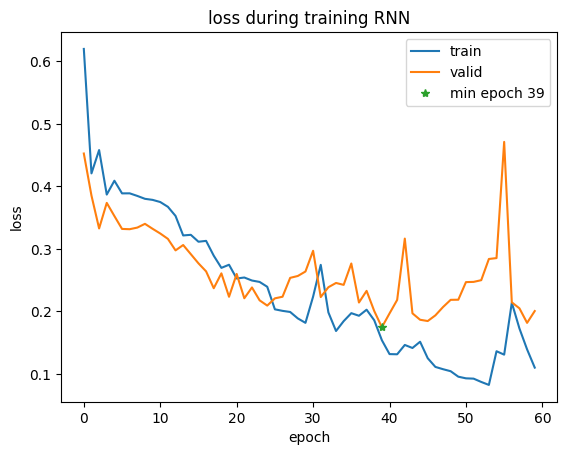

Found local copy...
Loading...


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['HIA_Hou']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/HIA_Hou_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/HIA_Hou_char_ST.pt
PAMPA_NCATS
collect data for:  ['PAMPA_NCATS']


Done!


train: 1424 | valid: 203 | test: 407 | total: 2034
Alphabet:None



---> loader for ['PAMPA_NCATS']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 35
Model type:  RNN | Model parameters:  2948298
Epoch:0, [Train] Loss: 0.519
Epoch:0, [Valid] Loss: 0.451
	 SAVE MODEL: loss: inf -> 0.451 | runtime: 1.024 ms
Epoch:1, [Train] Loss: 0.416
Epoch:1, [Valid] Loss: 0.455
EarlyStopping counter: 1 out of 20
Epoch:2, [Train] Loss: 0.406
Epoch:2, [Valid] Loss: 0.442
	 SAVE MODEL: loss: 0.451 -> 0.442 | runtime: 0.966 ms
Epoch:3, [Train] Loss: 0.405
Epoch:3, [Valid] Loss: 0.447
EarlyStopping counter: 1 out of 20
Epoch:4, [Train] Loss: 0.404
Epoch:4, [Valid] Loss: 0.446
EarlyStopping counter: 2 out of 20
Epoch:5, [Train] Loss: 0.404
Epoch:5, [Valid] Loss: 0.442
EarlyStopping counter: 3 out of 20
Epoch:6, [Train] Loss: 0.402
Epoch:6, [Valid

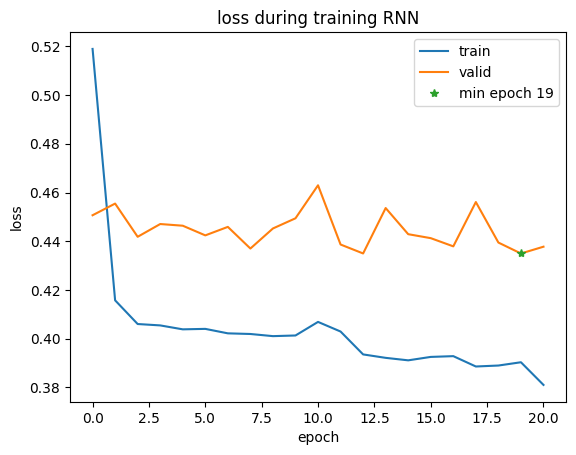

*************** PAMPA_NCATS ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.833  &  0.497  &          0.837  &     0.994  &0.000  &0.909 &0.591 &  -0.031 &   0.862

Epoch:21, [Train] Loss: 0.377
Epoch:21, [Valid] Loss: 0.454
EarlyStopping counter: 2 out of 20
Epoch:22, [Train] Loss: 0.392
Epoch:22, [Valid] Loss: 0.432
	 SAVE MODEL: loss: 0.435 -> 0.432 | runtime: 0.988 ms
Epoch:23, [Train] Loss: 0.379
Epoch:23, [Valid] Loss: 0.436
EarlyStopping counter: 1 out of 20
Epoch:24, [Train] Loss: 0.375
Epoch:24, [Valid] Loss: 0.437
EarlyStopping counter: 2 out of 20
Epoch:25, [Train] Loss: 0.378
Epoch:25, [Valid] Loss: 0.435
EarlyStopping counter: 3 out of 20
Epoch:26, [Train] Loss: 0.376
Epoch:26, [Valid] Loss: 0.424
	 SAVE MODEL: loss: 0.432 -> 0.424 | runtime: 1.033 ms
Epoch:27, [Train] Loss: 0.371
Epoch:27, [Valid] Loss: 0.422
	 SAVE MODEL: loss: 0.424 -> 0.422 | runtime: 1.059 ms
Epoch:28, [Train] Loss: 0.364
Epoch:28, [Valid] Lo

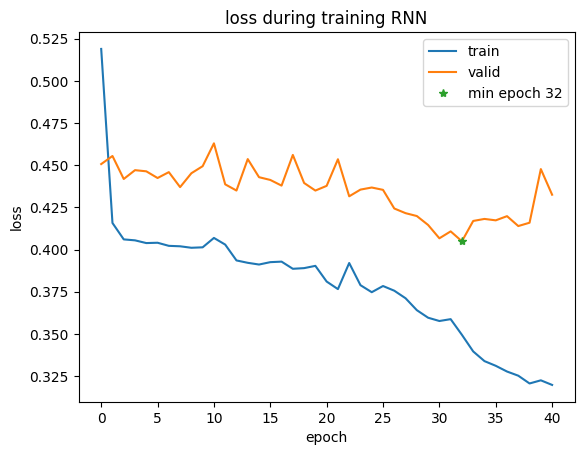

*************** PAMPA_NCATS ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.833  &  0.546  &          0.851  &     0.971  &0.121  &0.907 &0.675 &   0.165 &   0.885

Epoch:41, [Train] Loss: 0.303
Epoch:41, [Valid] Loss: 0.435
EarlyStopping counter: 9 out of 20
Epoch:42, [Train] Loss: 0.314
Epoch:42, [Valid] Loss: 0.436
EarlyStopping counter: 10 out of 20
Epoch:43, [Train] Loss: 0.312
Epoch:43, [Valid] Loss: 0.446
EarlyStopping counter: 11 out of 20
Epoch:44, [Train] Loss: 0.304
Epoch:44, [Valid] Loss: 0.456
EarlyStopping counter: 12 out of 20
Epoch:45, [Train] Loss: 0.297
Epoch:45, [Valid] Loss: 0.429
EarlyStopping counter: 13 out of 20
Epoch:46, [Train] Loss: 0.287
Epoch:46, [Valid] Loss: 0.459
EarlyStopping counter: 14 out of 20
Epoch:47, [Train] Loss: 0.298
Epoch:47, [Valid] Loss: 0.465
EarlyStopping counter: 15 out of 20
Epoch:48, [Train] Loss: 0.277
Epoch:48, [Valid] Loss: 0.505
EarlyStopping counter: 16 out of 20
Epoch:49

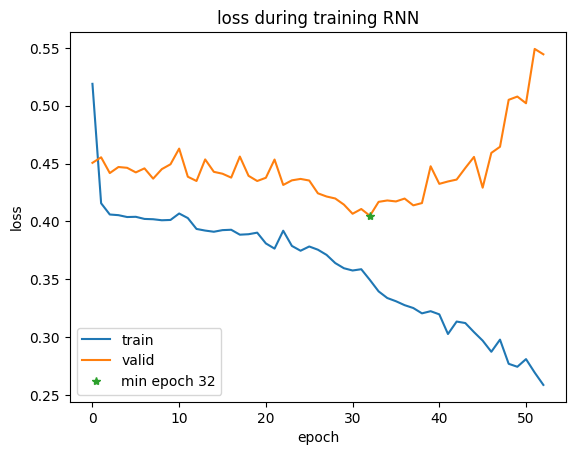

Found local copy...
Loading...


####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', '@', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'Na', 'O', 'P', 'S', '[', '\\', ']']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['PAMPA_NCATS']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/PAMPA_NCATS_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/PAMPA_NCATS_char_ST.pt
hERG_Karim
collect data for:  ['hERG_Karim']


Done!


train: 9412 | valid: 1344 | test: 2689 | total: 13445
Alphabet:None



---> loader for ['hERG_Karim']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 42
Model type:  RNN | Model parameters:  2959589
Epoch:0, [Train] Loss: 0.686
Epoch:0, [Valid] Loss: 0.675
	 SAVE MODEL: loss: inf -> 0.675 | runtime: 0.797 ms
Epoch:1, [Train] Loss: 0.651
Epoch:1, [Valid] Loss: 0.631
	 SAVE MODEL: loss: 0.675 -> 0.631 | runtime: 0.799 ms
Epoch:2, [Train] Loss: 0.621
Epoch:2, [Valid] Loss: 0.597
	 SAVE MODEL: loss: 0.631 -> 0.597 | runtime: 0.792 ms
Epoch:3, [Train] Loss: 0.605
Epoch:3, [Valid] Loss: 0.596
	 SAVE MODEL: loss: 0.597 -> 0.596 | runtime: 0.801 ms
Epoch:4, [Train] Loss: 0.610
Epoch:4, [Valid] Loss: 0.596
	 SAVE MODEL: loss: 0.596 -> 0.596 | runtime: 0.802 ms
Epoch:5, [Train] Loss: 0.599
Epoch:5, [Valid] Loss: 0.593
	 SAVE MODEL: los

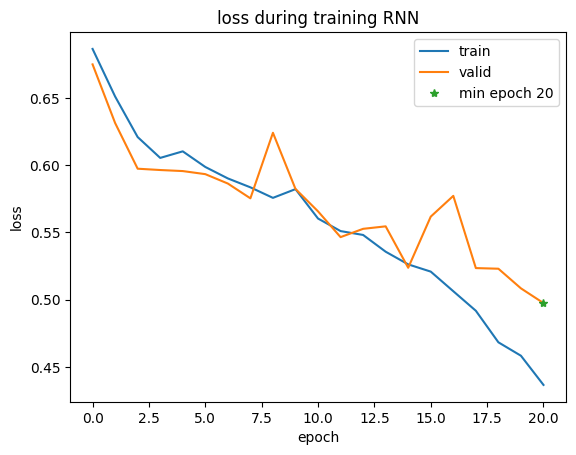

*************** hERG_Karim ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.768  &  0.768  &          0.771  &     0.752  &0.783  &0.761 &0.842 &   0.536 &   0.838

Epoch:21, [Train] Loss: 0.414
Epoch:21, [Valid] Loss: 0.492
	 SAVE MODEL: loss: 0.498 -> 0.492 | runtime: 0.791 ms
Epoch:22, [Train] Loss: 0.394
Epoch:22, [Valid] Loss: 0.492
EarlyStopping counter: 1 out of 20
Epoch:23, [Train] Loss: 0.370
Epoch:23, [Valid] Loss: 0.493
EarlyStopping counter: 2 out of 20
Epoch:24, [Train] Loss: 0.339
Epoch:24, [Valid] Loss: 0.506
EarlyStopping counter: 3 out of 20
Epoch:25, [Train] Loss: 0.327
Epoch:25, [Valid] Loss: 0.548
EarlyStopping counter: 4 out of 20
Epoch:26, [Train] Loss: 0.288
Epoch:26, [Valid] Loss: 0.522
EarlyStopping counter: 5 out of 20
Epoch:27, [Train] Loss: 0.276
Epoch:27, [Valid] Loss: 0.487
	 SAVE MODEL: loss: 0.492 -> 0.487 | runtime: 0.803 ms
Epoch:28, [Train] Loss: 0.235
Epoch:28, [Valid] Loss: 0.562
EarlyStoppi

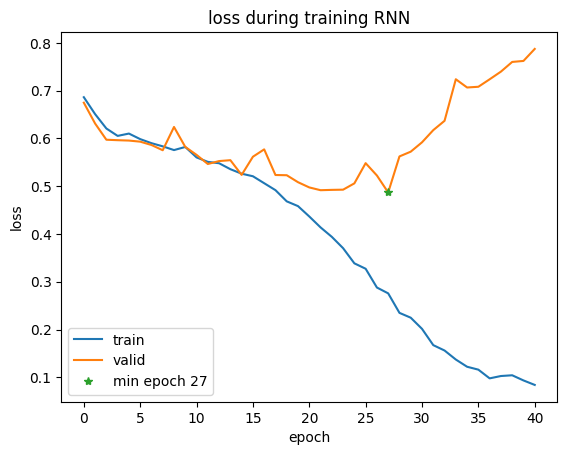

*************** hERG_Karim ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.803  &  0.802  &          0.826  &     0.759  &0.845  &0.791 &0.876 &   0.607 &   0.858

Epoch:41, [Train] Loss: 0.075
Epoch:41, [Valid] Loss: 0.876
EarlyStopping counter: 14 out of 20
Epoch:42, [Train] Loss: 0.066
Epoch:42, [Valid] Loss: 0.935
EarlyStopping counter: 15 out of 20
Epoch:43, [Train] Loss: 0.060
Epoch:43, [Valid] Loss: 0.826
EarlyStopping counter: 16 out of 20
Epoch:44, [Train] Loss: 0.066
Epoch:44, [Valid] Loss: 0.851
EarlyStopping counter: 17 out of 20
Epoch:45, [Train] Loss: 0.054
Epoch:45, [Valid] Loss: 0.917
EarlyStopping counter: 18 out of 20
Epoch:46, [Train] Loss: 0.050
Epoch:46, [Valid] Loss: 0.926
EarlyStopping counter: 19 out of 20
Epoch:47, [Train] Loss: 0.041
Epoch:47, [Valid] Loss: 0.969
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2959589
Train time: 0.801+/-0.006 ms
best epoch: 27, min loss: 0.4870


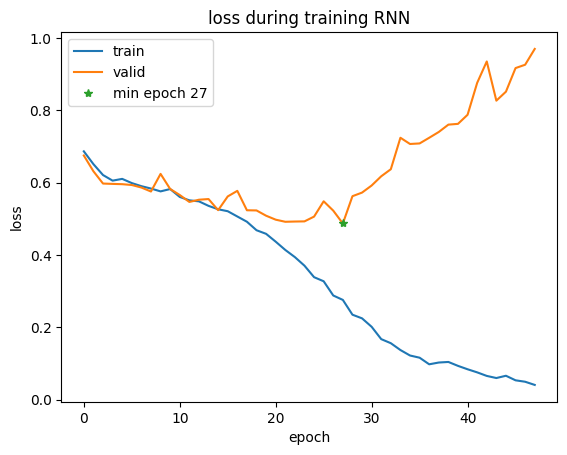

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'Au', 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'Na', 'O', 'P', 'S', 'Si', '[', '\\', ']', 'c', 'e', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['hERG_Karim']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size 

Found local copy...
Loading...


: 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/hERG_Karim_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/hERG_Karim_char_ST.pt
AMES
collect data for:  ['AMES']


Done!


train: 5094 | valid: 728 | test: 1456 | total: 7278
Alphabet:None



---> loader for ['AMES']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
RNN, no vocab provided, update vocab using dataset
updated vocab length: 37
Model type:  RNN | Model parameters:  2951514
Epoch:0, [Train] Loss: 0.659
Epoch:0, [Valid] Loss: 0.617
	 SAVE MODEL: loss: inf -> 0.617 | runtime: 0.778 ms
Epoch:1, [Train] Loss: 0.621
Epoch:1, [Valid] Loss: 0.598
	 SAVE MODEL: loss: 0.617 -> 0.598 | runtime: 0.789 ms
Epoch:2, [Train] Loss: 0.597
Epoch:2, [Valid] Loss: 0.616
EarlyStopping counter: 1 out of 20
Epoch:3, [Train] Loss: 0.593
Epoch:3, [Valid] Loss: 0.596
	 SAVE MODEL: loss: 0.598 -> 0.596 | runtime: 0.800 ms
Epoch:4, [Train] Loss: 0.595
Epoch:4, [Valid] Loss: 0.606
EarlyStopping counter: 1 out of 20
Epoch:5, [Train] Loss: 0.587
Epoch:5, [Valid] Loss: 0.583
	 SAVE MODEL: loss: 0.596 -> 0.583 | runtime: 0.783 ms
Epoch:6, [

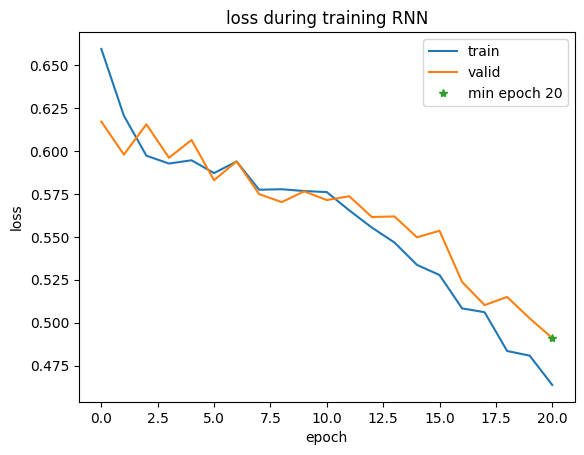

*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.772  &  0.767  &          0.801  &     0.801  &0.733  &0.801 &0.841 &   0.534 &   0.862

Epoch:21, [Train] Loss: 0.463
Epoch:21, [Valid] Loss: 0.491
	 SAVE MODEL: loss: 0.491 -> 0.491 | runtime: 0.774 ms
Epoch:22, [Train] Loss: 0.445
Epoch:22, [Valid] Loss: 0.475
	 SAVE MODEL: loss: 0.491 -> 0.475 | runtime: 0.792 ms
Epoch:23, [Train] Loss: 0.437
Epoch:23, [Valid] Loss: 0.481
EarlyStopping counter: 1 out of 20
Epoch:24, [Train] Loss: 0.418
Epoch:24, [Valid] Loss: 0.480
EarlyStopping counter: 2 out of 20
Epoch:25, [Train] Loss: 0.402
Epoch:25, [Valid] Loss: 0.479
EarlyStopping counter: 3 out of 20
Epoch:26, [Train] Loss: 0.401
Epoch:26, [Valid] Loss: 0.500
EarlyStopping counter: 4 out of 20
Epoch:27, [Train] Loss: 0.381
Epoch:27, [Valid] Loss: 0.495
EarlyStopping counter: 5 out of 20
Epoch:28, [Train] Loss: 0.359
Epoch:28, [Valid] Loss: 0.515
EarlyStopping cou

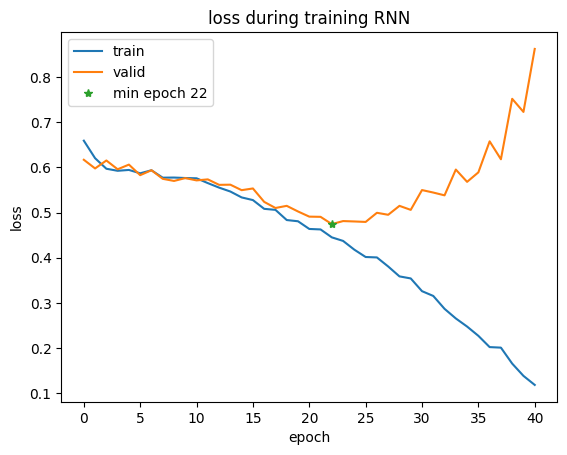

*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.777  &  0.776  &          0.818  &     0.787  &0.765  &0.802 &0.837 &   0.549 &   0.865

Epoch:41, [Train] Loss: 0.130
Epoch:41, [Valid] Loss: 0.742
EarlyStopping counter: 19 out of 20
Epoch:42, [Train] Loss: 0.109
Epoch:42, [Valid] Loss: 0.917
EarlyStopping counter: 20 out of 20
early stop
Model parameters:  2951514
Train time: 0.790+/-0.010 ms
best epoch: 22, min loss: 0.4746


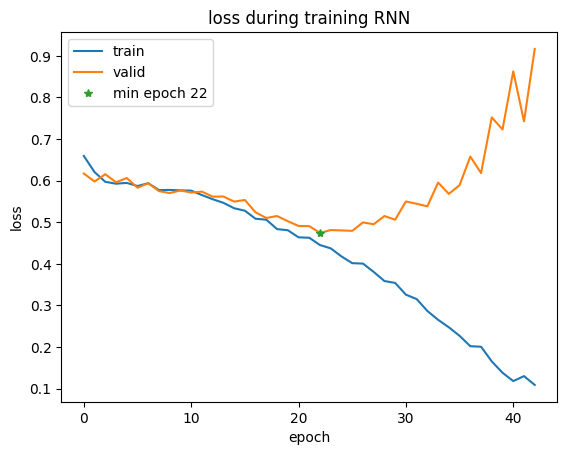

####################################################################
############################## CONFIG ##############################
####################################################################
model_type : RNN
vocab : ['<pad>', '<bos>', '<eos>', '<unk>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', '@', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'n', 'o', 's']
Bidirect : True
num_layers : 3
GRU_dim : 256
out_dim : 1
prop_names : ['AMES']
dropout : 0.1
IS_R : [False]
device : cuda
batch_size : 128
lr : 0.0005
wd : 1e-05
patience : 20
verbose_freq : 20
model_path : RNN/AMES_char_ST.pt
scale_dict : None
####################################################################
load pretrained model from  RNN/AMES_char_ST.pt


In [ ]:
Models, Configs, Test_loaders = [], [], []
model_type = 'RNN'

for name in list(names_dict.keys())[7:]:
    print(name)
    # if name != 'LD50_Zhu': pass
    # else: print(name)
    names = [name]
    trains, valids, tests = collect_data_10_27(names)
    print(f'train: {len(trains)} | valid: {len(valids)} | test: {len(tests)} | '
          f'total: {len(trains) + len(valids) + len(tests)}')
    config = get_config(model_type, names)
    if config['vocab'] == None: print('Alphabet:None\n\n\n')
    train_l, valid_l, test_l, vocab = get_multi_loader(trains, valids, tests, config)
    if vocab != None and config['vocab'] == None:
        config['vocab'] = vocab
        print('RNN, no vocab provided, update vocab using dataset')
        print('updated vocab length:', len(vocab))
    make_path('RNN/', False)
    config['model_path'] = f'RNN/{name}_char_ST.pt'
    Configs.append(config); Test_loaders.append(test_l)
    models = PRED(**config)
    models.train(train_l, valid_l, test_l)
    Models.append(models)

In [ ]:
label_list

['hERG_at_1uM', 'hERG_at_10uM', 'hERG_inhib']

In [ ]:
trains, valids, tests = collect_data_10_27(names)